<a href="https://colab.research.google.com/github/Khaled-Abdelhamid/Death-Big-data-Analytics/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Drive and setting up the environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"
# os.environ["SPARK_HOME"] ="/content/drive/MyDrive/Colab Notebooks/BigData/spark-2.4.7-bin-hadoop2.7"


In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [5]:
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, IntegerType, StringType

import json

In [20]:
import numpy as np 
import pandas as pd 
import time
import json
# import gc
# import xgboost as xgb 
# from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Data loading and exploration

In [7]:
start = time.time()
data_path="/content/drive/MyDrive/Colab Notebooks/BigData/Final project/Death-Big-data-Analytics/archive"
df=spark.read.options(header=True,inferSchema=True).csv(data_path)
df.show(truncate=False)
print((time.time()-start)/60)

+---------------+-----------------------+-----------------------+------------------------+--------------+---+---------------+----------+---------------------+-------------+-------------+-------------+--------------------+-----------------------------------+--------------+--------------------+-----------------+--------------+---------------+---------------------+-------+-------------+------------------------------------------------------+----------------------+----------------+----------------+-----------------------+---------------+--------------------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------------------+-----

In [8]:
df.dtypes # see the datatypes of each column

[('resident_status', 'string'),
 ('education_1989_revision', 'string'),
 ('education_2003_revision', 'string'),
 ('education_reporting_flag', 'string'),
 ('month_of_death', 'string'),
 ('sex', 'string'),
 ('detail_age_type', 'string'),
 ('detail_age', 'string'),
 ('age_substitution_flag', 'string'),
 ('age_recode_52', 'string'),
 ('age_recode_27', 'string'),
 ('age_recode_12', 'string'),
 ('infant_age_recode_22', 'string'),
 ('place_of_death_and_decedents_status', 'string'),
 ('marital_status', 'string'),
 ('day_of_week_of_death', 'string'),
 ('current_data_year', 'string'),
 ('injury_at_work', 'string'),
 ('manner_of_death', 'string'),
 ('method_of_disposition', 'string'),
 ('autopsy', 'string'),
 ('activity_code', 'string'),
 ('place_of_injury_for_causes_w00_y34_except_y06_and_y07_', 'string'),
 ('icd_code_10th_revision', 'string'),
 ('358_cause_recode', 'string'),
 ('113_cause_recode', 'string'),
 ('130_infant_cause_recode', 'string'),
 ('39_cause_recode', 'string'),
 ('number_of_en

In [9]:
# df2=spark.read.options(header=True,inferSchema=True).csv("/content/drive/MyDrive/Colab Notebooks/BigData/Final project/Death-Big-data-Analytics/archive/2015_data.csv")
df.groupBy('current_data_year').count().show()

+-----------------+-------+
|current_data_year|  count|
+-----------------+-------+
|             2012|2547963|
|             2014|2631270|
|             2013|2601551|
|             2005|2452605|
|            V89.9|      8|
|             null|   4517|
|current_data_year|      1|
|             2009|2441318|
|             2006|2430824|
|      N15.8-N15.9|      4|
|             2011|2519941|
|             2008|2476910|
|             2007|2428442|
|            U04)"|      3|
|          V89.9)"|      4|
|             2015|2718297|
|             2010|2472641|
+-----------------+-------+



In [10]:
df=df.filter("current_data_year in ('2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015')")
  


In [11]:
df=df.filter('sex in ("M","F")')

In [12]:
df.groupBy('sex').count().show()

+---+--------+
|sex|   count|
+---+--------+
|  F|13861407|
|  M|13860355|
+---+--------+



In [13]:
codes_path="/content/drive/MyDrive/Colab Notebooks/BigData/Final project/Death-Big-data-Analytics/archive/2015_codes.json"
with open(codes_path) as json_file:
    codes = json.load(json_file) 
codes

{'113_cause_recode': {'001': 'Salmonella infections (A01-A02)',
  '002': 'Shigellosis and amebiasis (A03,A06)',
  '003': 'Certain other intestinal infections (A04,A07-A09)',
  '004': 'Tuberculosis (A16-A19)',
  '005': 'Respiratory tuberculosis (A16)',
  '006': 'Other tuberculosis (A17-A19)',
  '007': 'Whooping cough (A37)',
  '008': 'Scarlet fever and erysipelas (A38,A46)',
  '009': 'Meningococcal infection (A39)',
  '010': 'Septicemia (A40-A41)',
  '011': 'Syphilis (A50-A53)',
  '012': 'Acute poliomyelitis (A80)',
  '013': 'Arthropod-borne viral encephalitis (A83-A84,A85.2)',
  '014': 'Measles (B05)',
  '015': 'Viral hepatitis (B15-B19)',
  '016': 'Human immunodeficiency virus (HIV) disease (B20-B24)',
  '017': 'Malaria (B50-B54)',
  '018': 'Other and unspecified infectious and parasitic diseases and their sequelae (A00,A05,A20-A36,A42-A44,A48-A49,A54-A79,A81-A82,A85.0-A85.1,A85.8, A86-B04,B06-B09,B25-B49,B55-B99)',
  '019': 'Malignant neoplasms (C00-C97)',
  '020': 'Malignant neoplas

# Getting the top 10 causes of death for each race

In [14]:
# df.groupBy('race','358_cause_recode','113_cause_recode','130_infant_cause_recode','39_cause_recode').count().show()
# df_deaths=df.groupBy('race','358_cause_recode','113_cause_recode','130_infant_cause_recode','39_cause_recode').count()
df_deaths=df.select(['race','39_cause_recode']).groupBy('race','39_cause_recode').count()


In [15]:
for race_id in codes['race'].keys(): 
  path=f'/content/drive/MyDrive/Colab Notebooks/BigData/Final project/results/COD_race/race_{race_id}.csv'
  df_deaths.filter(df_deaths.race==race_id)\
           .sort(F.desc("count")).limit(10)\
           .toPandas()\
           .to_csv(path,header=True)

# Getting the top 10 causes of death for each gender

In [ ]:
# df_deaths_gender=df.groupBy('sex','358_cause_recode','113_cause_recode','130_infant_cause_recode','39_cause_recode').count()
df_deaths_gender=df.groupBy('sex','39_cause_recode').count()


In [ ]:
df_deaths_gender.show()

In [ ]:
for gender_id in codes['sex'].keys(): 
  path=f'/content/drive/MyDrive/Colab Notebooks/BigData/Final project/results/COD_gender/gender_{gender_id}.csv'
  df_deaths_gender.filter(df_deaths_gender.sex==gender_id)\
           .sort(F.desc("count")).limit(20)\
           .toPandas()\
           .to_csv(path,header=True)

# The distributaion of death per weekday

In [ ]:
day_death=df.groupBy('day_of_week_of_death').count().sort(F.desc("count")).limit(7)\


In [ ]:
day_death.show()

# The distributaion of death per month

In [ ]:
month_death=df.groupBy('month_of_death').count().sort(F.desc("count")).limit(12)\


In [ ]:
month_death.show()

# Correlation between cause of death and the season timing

In [ ]:
seasons={"summer":("06","07","08"),
         "fall":("09","10","11"),
         "winter":("11","12","10"),
         "spring":("03","04","05")}


In [ ]:
# for season in seasons.keys(): 
#   path=f'/content/drive/MyDrive/Colab Notebooks/BigData/Final project/results/COD_season/season_{season}.csv'
#   m1,m2,m3=seasons[season]
#   df.filter((df.month_of_death==m1) | (df.month_of_death==m2) | (df.month_of_death==m3)).groupBy('358_cause_recode','113_cause_recode','130_infant_cause_recode','39_cause_recode').count()\
#     .sort(F.desc("count")).limit(20)\
#     .toPandas()\
#     .to_csv(path,header=True)

for season in seasons.keys(): 
  path=f'/content/drive/MyDrive/Colab Notebooks/BigData/Final project/results/COD_season/season_{season}.csv'
  m1,m2,m3=seasons[season]
  df.filter((df.month_of_death==m1) | (df.month_of_death==m2) | (df.month_of_death==m3)).groupBy('39_cause_recode').count()\
    .sort(F.desc("count")).limit(20)\
    .toPandas()\
    .to_csv(path,header=True)
           

# Correlation between cause of death, engagement and the month.

In [ ]:
seasons={"summer":("06","07","08"),
         "fall":("09","10","11"),
         "winter":("11","12","10"),
         "spring":("03","04","05")}


In [ ]:
# for season in seasons.keys(): 
#   path=f'/content/drive/MyDrive/Colab Notebooks/BigData/Final project/results/COD_activities/season_{season}.csv'
#   m1,m2,m3=seasons[season]
#   df.filter((df.month_of_death==m1) | (df.month_of_death==m2) | (df.month_of_death==m3)).groupBy('activity_code','358_cause_recode','113_cause_recode','130_infant_cause_recode','39_cause_recode').count()\
#     .sort(F.desc("count")).limit(20)\
#     .toPandas()\
#     .to_csv(path,header=True)

for season in seasons.keys(): 
  path=f'/content/drive/MyDrive/Colab Notebooks/BigData/Final project/results/COD_activities/season_{season}.csv'
  m1,m2,m3=seasons[season]
  df.filter((df.month_of_death==m1) | (df.month_of_death==m2) | (df.month_of_death==m3)).groupBy('activity_code','39_cause_recode').count()\
    .sort(F.desc("count")).limit(20)\
    .toPandas()\
    .to_csv(path,header=True)
           

# Cause of death distribution for each year

In [ ]:
years=["2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015"]

In [ ]:
for year in years: 
  path=f'/content/drive/MyDrive/Colab Notebooks/BigData/Final project/results/COD_per_year/year_{year}.csv'
  df.filter(df.current_data_year==year).groupBy('current_data_year','358_cause_recode','113_cause_recode','130_infant_cause_recode','39_cause_recode').count()\
    .sort(F.desc("count")).limit(20)\
    .toPandas()\
    .to_csv(path,header=True)
           

# Visulaization

In [293]:
#Python3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
# sns.color_palette("hls", 13)


In [294]:
def bar_plot(x,y,df,title,path):
  # Defining the plot size 
  plt.figure(figsize=(20, 12)) 
    
  # Defining the values for x-axis, y-axis 
  # and from which datafarme the values are to be picked 
  plots = sns.barplot(x=x, y=y, data=df) 
    
  # Iterrating over the bars one-by-one 
  for bar in plots.patches: 
      
    # Using Matplotlib's annotate function and 
    # passing the coordinates where the annotation shall be done 
    # x-coordinate: bar.get_x() + bar.get_width() / 2 
    # y-coordinate: bar.get_height() 
    # free space to be left to make graph pleasing: (0, 8) 
    # ha and va stand for the horizontal and vertical alignment 
    plots.annotate(format(bar.get_height(), '.0f'),  
                    (bar.get_x() + bar.get_width() / 2,  
                      bar.get_height()), ha='center', va='center', 
                    size=15, xytext=(0, 8), 
                    textcoords='offset points') 
    
  # Setting the label for x-axis 
  plt.xlabel("cause of death", size=14) 
    
  # Setting the label for y-axis 
  plt.ylabel("Death count", size=14) 
    
  # Setting the title for the graph 
  plt.title(title) 
    
  # Fianlly showing the plot 
  plt.show() 
  # plt.savefig(path)


In [295]:
codes_path="/content/drive/MyDrive/Colab Notebooks/BigData/Final project/Death-Big-data-Analytics/archive/2015_codes.json"
with open(codes_path) as json_file:
    codes = json.load(json_file) 
codes

{'113_cause_recode': {'001': 'Salmonella infections (A01-A02)',
  '002': 'Shigellosis and amebiasis (A03,A06)',
  '003': 'Certain other intestinal infections (A04,A07-A09)',
  '004': 'Tuberculosis (A16-A19)',
  '005': 'Respiratory tuberculosis (A16)',
  '006': 'Other tuberculosis (A17-A19)',
  '007': 'Whooping cough (A37)',
  '008': 'Scarlet fever and erysipelas (A38,A46)',
  '009': 'Meningococcal infection (A39)',
  '010': 'Septicemia (A40-A41)',
  '011': 'Syphilis (A50-A53)',
  '012': 'Acute poliomyelitis (A80)',
  '013': 'Arthropod-borne viral encephalitis (A83-A84,A85.2)',
  '014': 'Measles (B05)',
  '015': 'Viral hepatitis (B15-B19)',
  '016': 'Human immunodeficiency virus (HIV) disease (B20-B24)',
  '017': 'Malaria (B50-B54)',
  '018': 'Other and unspecified infectious and parasitic diseases and their sequelae (A00,A05,A20-A36,A42-A44,A48-A49,A54-A79,A81-A82,A85.0-A85.1,A85.8, A86-B04,B06-B09,B25-B49,B55-B99)',
  '019': 'Malignant neoplasms (C00-C97)',
  '020': 'Malignant neoplas

In [296]:
cause_recode=codes["39_cause_recode"]
# cause_recode={int(k):v for k,v in cause_recode.items()}

In [297]:
cause_recode={1:'Tuberculosis ',
 2: 'Syphilis',
 3: 'HIV',
 4: 'Cancer',
 5: 'Cancer',
 6: 'Cancer',
 7: 'Cancer',
 8: 'Cancer',
 9: 'Cancer',
 10: 'Cancer',
 11: 'Cancer',
 12: 'Cancer',
 13: "Cancer",
 14: 'Cancer',
 15: 'Cancer',
 16: 'Diabetes',
 17: "Alzheimer's disease",
 18: 'Cardiovascular disease',
 19: 'Cardiovascular disease',
 20: 'Cardiovascular disease',
 21: 'Cardiovascular disease',
 22: 'Cardiovascular disease',
 23: 'Cardiovascular disease',
 24: 'Cardiovascular disease',
 25: 'Cardiovascular disease',
 26: 'Cardiovascular disease',
 27: 'Respiratory diseases ',
 28: 'Respiratory diseases ',
 29: 'Peptic ulcer (K25-K28)',
 30: 'Chronic liver disease and cirrhosis (K70,K73-K74)',
 31: 'Nephritis, nephrotic syndrome, and nephrosis (N00-N07,N17-N19,N25-N27)',
 32: 'Pregnancy, childbirth and the puerperium (O00-O99)',
 33: 'Certain conditions originating in the perinatal period (P00-P96)',
 34: 'Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)',
 35: 'Sudden infant death syndrome (R95)',
 36: 'Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (excluding Sudden infant death syndrome) (R00-R94,R96-R99)',
 37: 'Other diseases',
 38: 'Motor vehicle accidents (V02-V04,V09.0,V12-V14,V19.0-V19.2,V19.4-V19.6, V20-V79,V80.3-V80.5,V81.0-V81.1,V82.0-V82.1,V83-V86,V87.0-V87.8, V88.0-V88.8,V89.0,V89.2)',
 39: 'Accidents',
 40: 'Suicide',
 41: 'Assault (homicide) (*U01-*U02,X85-Y09,Y87.1)',
 42: 'All other external causes (Y10-Y36,Y87.2,Y89)'}

In [298]:
cause_recode_big=codes["358_cause_recode"]
cause_recode_big={int(k):v for k,v in cause_recode_big.items()}
cause_recode_big

{1: 'I.  Certain infectious and parasitic diseases (A00-B99)',
 2: 'Intestinal infectious diseases (A00-A09)',
 3: 'Cholera (A00)',
 4: 'Other intestinal infectious diseases (A01-A08)',
 5: 'Typhoid fever (A01.0)',
 6: 'Paratyphoid fevers and other salmonella infections (A01.1-A01.4,A02)',
 7: 'Shigellosis (A03)',
 8: 'Other bacterial food-borne intoxications (A05)',
 9: 'Amebiasis (A06)',
 10: 'Intestinal infections due to other specified organisms (A04,A07-A08)',
 11: 'Diarrhea and gastroenteritis of infectious origin (A09)',
 12: 'Tuberculosis (A16-A19)',
 13: 'Respiratory tuberculosis (A16)',
 14: 'Other tuberculosis (A17-A19)',
 15: 'Zoonotic and other bacterial diseases (A20-A49)',
 16: 'Plague (A20)',
 17: 'Brucellosis (A23)',
 18: 'Tetanus (A33-A35)',
 19: 'Diptheria (A36)',
 20: 'Whooping cough (A37)',
 21: 'Scarlet fever and erysipelas (A38,A46)',
 22: 'Meningococcal infection (A39)',
 23: 'Septicemia (A40-A41)',
 24: 'Other zoonotic and bacterial diseases (A21-A22,A24-A32,A4

In [299]:
cause_recode_big={1: 'I.  Certain infectious and parasitic diseases (A00-B99)',
 2: 'Intestinal infectious diseases (A00-A09)',
 3: 'Cholera (A00)',
 4: 'Other intestinal infectious diseases (A01-A08)',
 5: 'Typhoid fever (A01.0)',
 6: 'Paratyphoid fevers and other salmonella infections (A01.1-A01.4,A02)',
 7: 'Shigellosis (A03)',
 8: 'Other bacterial food-borne intoxications (A05)',
 9: 'Amebiasis (A06)',
 10: 'Intestinal infections due to other specified organisms (A04,A07-A08)',
 11: 'Diarrhea and gastroenteritis of infectious origin (A09)',
 12: 'Tuberculosis (A16-A19)',
 13: 'Respiratory tuberculosis (A16)',
 14: 'Other tuberculosis (A17-A19)',
 15: 'Zoonotic and other bacterial diseases (A20-A49)',
 16: 'Plague (A20)',
 17: 'Brucellosis (A23)',
 18: 'Tetanus (A33-A35)',
 19: 'Diptheria (A36)',
 20: 'Whooping cough (A37)',
 21: 'Scarlet fever and erysipelas (A38,A46)',
 22: 'Meningococcal infection (A39)',
 23: 'Septicemia (A40-A41)',
 24: 'Other zoonotic and bacterial diseases (A21-A22,A24-A32,A42-A44, A48-A49)',
 25: 'Infections with a predominately sexual mode of transmission (A50-A64)',
 26: 'Syphilis (A50-A53)',
 27: 'Cardiovascular syphilis (A52.0)',
 28: 'Neurosyphilis (A52.1-A52.3)',
 29: 'Other and unspecified syphilis (A50-A51,A52.7-A52.9,A53)',
 30: 'Gonococcal infection (A54)',
 31: 'Other infections with a predominately sexual mode of transmission (A55-A64)',
 32: 'Other infections caused by spirochetes, chlamydia or rickettsia (A65-A79)',
 33: 'Lyme disease (A69.2)',
 34: 'Typhus fever (A75)',
 35: 'All other infections caused by spirochetes, chlamydia or rickettsia (A65-A68,A69.0-A69.1,A69.8-A69.9,A70-A74,A77-A79)',
 36: 'Viral diseases (A80-B34)',
 37: 'Acute poliomyelitis (A80)',
 38: 'Rabies (A82)',
 39: 'Arthropod-borne viral encephalitis (A83-A84,A85.2)',
 40: 'Yellow fever (A95)',
 41: 'Other and unspecified arthropod-borne viral and hemorrhagic fevers (A90-A94,A96-A99)',
 42: 'Herpesviral (herpes simplex) infections (B00)',
 43: 'Zoster (herpes zoster) (B02)',
 44: 'Smallpox (B03)',
 45: 'Measles (B05)',
 46: 'Rubella (German measles) (B06)',
 47: 'Viral hepatitis (B15-B19)',
 48: 'Human immunodeficiency virus (HIV) disease (B20-B24)',
 49: 'Human immunodeficiency virus (HIV) disease resulting in infectious and parasitic diseases (B20)',
 50: 'Human immunodeficiency virus (HIV) disease resulting in malignant neoplasms (B21)',
 51: 'Human immunodeficiency virus (HIV) disease resulting in other specified diseases (B22)',
 52: 'Human immunodeficiency virus (HIV) disease resulting in other conditions (B23)',
 53: 'Unspecified human immunodeficiency virus (HIV) disease (B24)',
 54: 'All other and unspecified viral diseases (A81,A85.0-A85.1,A85.8, A86-A89,B01,B04,B07-B09,B25-B34)',
 55: 'Other and unspecified infectious and parasitic diseases and their sequelae (B35-B99)',
 56: 'Mycoses (B35-B49)',
 57: 'Protozoal diseases (B50-B64)',
 58: 'Malaria (B50-B54)',
 59: 'Leishmaniasis (B55)',
 60: 'Trypanosomiasis (B56-B57)',
 61: 'Pneumocystosis (B59)',
 62: 'Other and unspecified protozoal diseases (B58,B60-B64)',
 63: 'Helminthiases (B65-B83)',
 64: 'Schistosomiasis (bilharziasis) (B65)',
 65: 'Other and unspecified helminthiases (B66-B83)',
 66: 'Sequelae of tuberculosis (B90)',
 67: 'Sequelae of poliomyelitis (B91)',
 68: 'All other and unspecified infectious and parasitic diseases and their sequelae (B85-B89,B92-B99)',
 69: 'Cancer',
 70: 'Cancer',
 71: 'Cancer',
 72: 'Cancer',
 73: 'Cancer',
 74: 'Cancer',
 75: 'Cancer',
 76: 'Cancer',
 77: 'Cancer',
 78: 'Cancer',
 79: 'Cancer',
 80: 'Cancer',
 81: 'Cancer',
 82: 'Cancer',
 83: 'Cancer',
 84: 'Cancer',
 85: 'Cancer',
 86: 'Cancer',
 87: 'Cancer',
 88: 'Cancer',
 89: 'Cancer',
 90: 'Cancer',
 91: 'Cancer',
 92: 'Cancer',
 93: 'Cancer',
 94: 'Cancer',
 95: 'Cancer',
 96: 'Cancer',
 97: 'Cancer',
 98: 'Cancer',
 99: 'Cancer',
 100: 'Cancer',
 101: 'Cancer',
 102: 'Cancer',
 103: 'Cancer',
 104: 'Cancer',
 105: 'Cancer',
 106: 'Cancer',
 107: 'Cancer',
 108: 'Cancer',
 109: 'Cancer',
 110: 'Cancer',
 111: 'Cancer',
 112: 'Cancer',
 113: 'Cancer',
 114: 'Cancer',
 115: 'Cancer',
 116: 'Cancer',
 117: 'Cancer',
 118: 'Cancer',
 119: 'Cancer',
 120: 'Cancer',
 121: 'Cancer',
 122: 'Cancer',
 123: 'Cancer',
 124: 'Cancer',
 125: 'Cancer',
 126: 'Cancer',
 127: 'Cancer',
 128: 'Cancer',
 129: 'Cancer',
 130: 'Cancer',
 131: 'Cancer',
 132: 'Cancer',
 133: 'Cancer',
 134: 'Cancer',
 135: 'Cancer',
 136: 'Cancer',
 137: 'Cancer',
 138: 'In situ neoplasms (D00-D09)',
 139: 'Carcinoma in situ of breast and genitourinary system (D05-D07)',
 140: 'Carcinoma in situ of other and unspecified sites (D00-D04,D09)',
 141: 'Benign neoplasms (D10-D36)',
 142: 'Of female genital organs (D25-D28)',
 143: 'Of eye, brain and other parts of central nervous system (D31-D33)',
 144: 'Of other and unspecified sites (D10-D24,D29-D30,D34-D36)',
 145: 'Neoplasms of uncertain or unknown behavior of specified sites (D37-D47)',
 146: 'Neoplasms of uncertain or unknown behavior of unspecified sites (D48)',
 147: 'III. Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism (D50-D89)',
 148: 'Anemias (D50-D64)',
 149: 'Nutritional anemias (D50-D53)',
 150: 'Hemolytic anemias (D55-D59)',
 151: 'Aplastic anemias (D60-D61)',
 152: 'Acute posthemorrhagic and other anemias (D62,D64)',
 153: 'Coagulation defects, purpura and other hemorrhagic conditions (D65-D69)',
 154: 'Other diseases of blood and blood-forming organs (D70-D76)',
 155: 'Certain disorders involving the immune mechanism (D80-D89)',
 156: 'Diabetes',
 157: 'Diabetes',
 158: 'Diabetes',
 159: 'Diabetes',
 160: 'Diabetes',
 161: 'Diabetes',
 162: 'Diabetes',
 163: 'Diabetes',
 164: 'Diabetes',
 165: 'Diabetes',
 166: 'Diabetes',
 167: 'Diabetes',
 168: 'Diabetes',
 169: 'Diabetes',
 170: 'Diabetes',
 171: 'Diabetes',
 172: 'Diabetes',
 173: 'Diabetes',
 174: 'V.  Mental and behavioral disorders (F01-F99)',
 175: 'Organic dementia',
 176: 'Other and unspecified organic mental disorders (F04-F09)',
 177: 'Mental and behavioral disorders due to psychoactive substance use (F10-F19)',
 178: 'Mental and behavioral disorders due to use of alcohol (F10)',
 179: 'Mental and behavioral disorders due to other psychoactive substance use (F11-F19)',
 180: 'Schizophrenia, schizotypal and delusional disorders (F20-F29)',
 181: 'Mood (affective) disorders (F30-F39)',
 182: 'Neurotic, stress-related and somatoform disorders (F40-F48)',
 183: 'Mental retardation (F70-F79)',
 184: 'Other and unspecified mental and behavioral disorders (F50-F69,F80-F99)',
 185: 'VI. Diseases of the nervous system (G00-G98)',
 186: 'Meningitis (G00,G03)',
 187: 'Other inflammatory diseases of central nervous system (G04-G09)',
 188: 'Parkinson=s disease (G20-G21)',
 189: "Alzheimer's",
 190: 'Multiple sclerosis (G35)',
 191: 'Epilepsy (G40-G41)',
 192: 'Transient cerebral ischemic attacks and related syndromes (G45)',
 193: 'Infantile cerebral palsy (G80)',
 194: 'All other diseases of nervous system (G10-G14,G23-G25,G31,G36-G37,G43-G44,G47-G72,G81-G98)',
 195: 'VII. Diseases of the eye and adnexa (H00-H57)',
 196: 'VIII. Diseases of the ear and mastoid process (H60-H93)',
 197: 'Cardiovascular',
 198: 'Cardiovascular',
 199: 'Cardiovascular',
 200: 'Cardiovascular',
 201: 'Cardiovascular',
 202: 'Cardiovascular',
 203: 'Cardiovascular',
 204: 'Cardiovascular',
 205: 'Cardiovascular',
 206: 'Cardiovascular',
 207: 'Cardiovascular',
 208: 'Cardiovascular',
 209: 'Cardiovascular',
 210: 'Cardiovascular',
 211: 'Cardiovascular',
 212: 'Cardiovascular',
 213: 'Cardiovascular',
 214: 'Cardiovascular',
 215: 'Cardiovascular',
 216: 'Cardiovascular',
 217: 'Cardiovascular',
 218: 'Cardiovascular',
 219: 'Cardiovascular',
 220: 'Cardiovascular',
 221: 'Cardiovascular',
 222: 'Cardiovascular',
 223: 'Cardiovascular',
 224: 'Cardiovascular',
 225: 'Cardiovascular',
 226: 'Cardiovascular',
 227: 'Cardiovascular',
 228: 'Cardiovascular',
 229: 'Cardiovascular',
 230: 'Cardiovascular',
 231: 'Cardiovascular',
 232: 'Cardiovascular',
 233: 'Cardiovascular',
 234: 'Cardiovascular',
 235: 'Cardiovascular',
 236: 'Cardiovascular',
 237: 'Cardiovascular',
 238: 'Cardiovascular',
 239: 'Cardiovascular',
 240: 'Cardiovascular',
 241: 'Cardiovascular',
 242: 'Cardiovascular',
 243: 'Cardiovascular',
 244: 'Cardiovascular',
 245: 'Cardiovascular',
 246: 'Cardiovascular',
 247: 'Respiratory disease',
 248: 'Respiratory disease',
 249: 'Respiratory disease',
 250: 'Respiratory disease',
 251: 'Respiratory disease',
 252: 'Respiratory disease',
 253: 'Respiratory disease',
 254: 'Respiratory disease',
 255: 'Respiratory disease',
 256: 'Respiratory disease',
 257: 'Respiratory disease',
 258: 'Respiratory disease',
 259: 'Respiratory disease',
 260: 'Respiratory disease',
 261: 'Respiratory disease',
 262: 'Respiratory disease',
 263: 'Respiratory disease',
 264: 'Respiratory disease',
 265: 'Respiratory disease',
 266: 'Respiratory disease',
 267: 'Respiratory disease',
 268: 'Respiratory disease',
 269: 'Respiratory disease',
 270: 'Respiratory disease',
 271: 'Respiratory disease',
 272: 'Respiratory disease',
 273: 'Respiratory disease',
 274: 'Respiratory disease',
 275: 'Respiratory disease',
 276: 'Respiratory disease',
 277: 'Respiratory disease',
 278: 'Respiratory disease',
 279: 'XI. Diseases of the digestive system (K00-K92)',
 280: 'Diseases of oral cavity, salivary glands and jaws (K00-K14)',
 281: 'Diseases of other parts of digestive system (K20-K92)',
 282: 'Diseases of esophagus (K20-K22)',
 283: 'Peptic ulcer (K25-K28)',
 284: 'Gastric ulcer(K25)',
 285: 'Duodenal ulcer(K26)',
 286: 'Peptic ulcer, site unspecified (K27)',
 287: 'Gastrojejunal ulcer (K28)',
 288: 'Gastritis and duodenitis (K29)',
 289: 'Dyspepsia and other diseases of stomach and duodenum (K30-K31)',
 290: 'Diseases of appendix (K35-K38)',
 291: 'Hernia (K40-K46)',
 292: 'Crohn=s disease and ulcerative colitis (K50-K51)',
 293: 'Vascular disorders and obstruction of intestine without hernia (K55-K56)',
 294: 'Diverticular disease of intestine (K57)',
 295: 'Other diseases of intestines and peritoneum (K52,K58-K63)',
 296: 'Diseases of peritoneum (K65-K66)',
 297: 'Diseases of liver (K70-K76)',
 298: 'Alcoholic liver disease (K70)',
 299: 'Chronic hepatitis, not elsewhere classified (K73)',
 300: 'Fibrosis and cirrhosis of liver (K74)',
 301: 'Other diseases of liver (K71-K72,K75-K76)',
 302: 'Cholelithiasis and other disorders of gallbladder (K80-K82)',
 303: 'Disorders of biliary tract and pancreas (K83-K86)',
 304: 'Pancreatitis (K85,K86.0-K86.1)',
 305: 'Other disorders of biliary tract and pancreas (K83,K86.2-K86.9)',
 306: 'All other diseases of digestive system (K90-K92)',
 307: 'XII. Diseases of the skin and subcutaneous tissue (L00-L98)',
 308: 'Infections of skin and subcutaneous tissue (L00-L08)',
 309: 'Other and unspecified diseases of skin and sub-cutaneous tissue (L10-L98)',
 310: 'XIII. Diseases of the musculoskeletal system and connective tissue (M00-M99)',
 311: 'Rheumatoid arthritis and related inflammatory polyarthropathies (M05-M08)',
 312: 'Systemic lupus erythematosus (M32)',
 313: 'Other arthropathies and related disorders (M00,M02,M10-M31,M33-M35)',
 314: 'Dorsopathies (M40-M54)',
 315: 'Soft tissue disorders (M60-M79)',
 316: 'Osteopathies, chondropathies and other disorders of musculoskeletal system and connective tissue (M80-M99)',
 317: 'Osteoporosis (M80-M81)',
 318: 'Other osteopathies, chondropathies and disorders of musculoskeletal system and connective tissue (M83-M99)',
 319: 'XIV. Diseases of the genitourinary system (N00-N98)',
 320: 'Diseases of urinary system (N00-N39)',
 321: 'Glomerular and renal tubulo-interstitial diseases (N00-N15)',
 322: 'Glomerular diseases (N00-N07)',
 323: 'Acute and rapidly progressive nephritic syndrome (N00-N01)',
 324: 'Nephrotic syndrome (N04)',
 325: 'Other and unspecified glomerular diseases (N02-N03,N05-N07)',
 326: 'Renal tubulo-interstitial diseases (N10-N15)',
 327: 'Renal failure (N17-N19)',
 328: 'Urolithiasis (N20-N23)',
 329: 'Other and unspecified disorders of kidney (N25-N27)',
 330: 'Urinary tract infection, site not specified (N39.0)',
 331: 'Other diseases of urinary system (N28-N36,N39.1-N39.9)',
 332: 'Diseases of male genital organs (N40-N50)',
 333: 'Hyperplasia of prostate (N40)',
 334: 'Other diseases of male genital organs (N41-N50)',
 335: 'Disorders of breast (N60-N64)',
 336: 'Disorders of female genital organs (N70-N98)',
 337: 'Inflammatory diseases of female pelvic organs (N70-N76)',
 338: 'Noninflammatory disorders of female genital tract (N80-N98)',
 339: 'XV. Pregnancy, childbirth and the puerperium (O00-O99)',
 340: 'Pregnancy with abortive outcome (O00-O07)',
 341: 'Ectopic pregnancy (O00)',
 342: 'Spontaneous abortion (O03)',
 343: 'Medical abortion (O04)',
 344: 'Other abortion (O05)',
 345: 'Other and unspecified pregnancy with abortive outcome (O01-O02,O06-O07)',
 346: 'Other direct obstetric deaths (O10-O92)',
 347: 'Eclampsia and pre-eclampsia (O11,O13-O16)',
 348: 'Hemorrhage of pregnancy and childbirth and placenta previa (O20,O44-O46,O67,072)',
 349: 'Complications predominately related to the puerperium (O85-O92)',
 350: 'Obstetric embolism (O88)',
 351: 'Other complications predominately related to the puerperium (O85-O87,O89-O92)',
 352: 'All other direct obstetric causes (O10,O12,O21-O43,O47-O66,O68-O71, O73-O75)',
 353: 'Obstetric death of unspecified cause (O95)',
 354: 'Other deaths related to pregnancy, childbirth and the puerperium (O96-O97)',
 355: 'Indirect obstetric deaths (O98-O99)',
 356: 'XVI. Certain conditions originating in the perinatal period (P00-P96)',
 357: 'Newborn affected by maternal factors and by complications of pregnancy, labor and delivery (P00-P04)',
 358: 'Disorders related to short gestation and low birth weight, not elsewhere classified (P07)',
 359: 'Birth trauma (P10-P15)',
 360: 'Intrauterine hypoxia and birth asphyxia (P20-P21)',
 361: 'Respiratory distress of newborn (P22)',
 362: 'Other respiratory conditions originating in the perinatal period (P23-P28)',
 363: 'Infections specific to the perinatal period (P35-P39)',
 364: 'Other and unspecified conditions originating in the perinatal period (P05,P08,P29,P50-P96)',
 365: 'XVII. Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)',
 366: 'Anencephaly and similar malformations (Q00)',
 367: 'Spina bifida (Q05)',
 368: 'All other congenital malformations of nervous system (Q01-Q04,Q06-Q07)',
 369: 'Congenital malformations of heart (Q20-Q24)',
 370: 'Other congenital malformations of circulatory system (Q25-Q28)',
 371: 'Congenital malformations of respiratory system (Q30-Q34)',
 372: 'Other congenital malformations and deformations (Q10-Q18,Q35-Q89)',
 373: 'Down=s syndrome (Q90)',
 374: 'All other chromosomal abnormalities, not elsewhere classified (Q91-Q99)',
 375: 'XVIII. Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (R00-R99)',
 376: 'Senility (R54)',
 377: 'Ill-defined and unknown causes of mortality (R95-R99)',
 378: 'Sudden infant death syndrome (R95)',
 379: 'Other ill-defined and unknown causes of mortality (R96-R99)',
 380: 'All other symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (R00-R53,R55-R94)',
 381: 'XX.External causes of mortality (*U01-*U03,V01-Y89)',
 382: 'Accidents (unintentional injuries) (V01-X59,Y85-Y86)',
 383: 'Transport accidents (V01-V99, Y85)',
 384: 'Railway accidents (V05,V15,V80.6,V81.2-V81.9)',
 385: 'Motor vehicle accidents (V02-V04,V09.0,V09.2,V12-V14,V19.0-V19.2, V19.4-V19.6,V20-V79,V80.3-V80.5,V81.0-V81.1,V82.0-V82.1,V83-V86, V87.0-V87.8,V88.0-V88.8,V89.0,V89.2)',
 386: 'Pedestrian involved in collision with motor vehicle (V02-V04)',
 387: 'Pedalcyclist involved in collision with motor vehicle (V12-V14,V19.0,V19.2-V19.4-V19.6)',
 388: 'Motorcyclist involved in any accident except collision with railway train (V20-V24,V26-V34,V36-V39)',
 389: 'Motor vehicle accident involving collision with railway train (V25,V35,V45,V55,V65,V75,V81.0-V81.1,V87.6,V88.6)',
 390: 'Motorcyclist involved in collision with railway train (V25,V35)',
 391: 'Other motor vehicle accident involving collision with railway train (V45,V55,V65,V75,V81.0-V81.1,V87.6,V88.6)',
 392: 'Occupant of motor vehicle involved in collision with other (non- motorized) road vehicle, streetcar, animal or pedestrian (V40-V41,V46-V47,V50-V51,V56-V57,V60-V61,V66-V67,V70-V71, V76-V77)',
 393: 'Occupant of car, pickup truck or van involved in collision with other motor vehicle (V42-V44,V49,V52-V54,V59)',
 394: 'Occupant of heavy transport vehicle or bus involved in collision with other motor vehicle (V62-V64,V69,V72-V74,V79)',
 395: 'Occupant of motor vehicle involved in non-collision accident (V48,V58,V68,V78)',
 396: 'Occupant of special-use motor vehicle involved in any accident (V83-V86)',
 397: 'Other and unspecified motor vehicle accidents (V09.0,V09.2,V80.3-V80.5,V82.0-V82.1,V87.0-V87.5,V87.7-V87.8, V88.0-V88.5,V88.7-V88.8,V89.0,V89.2)',
 398: 'Streetcar accidents (V82.2-V82.9)',
 399: 'Other and unspecified land transport accidents (V01,V06,V09.1,V09.3,V09.9,V10-V11,V16-V18,V19.3,V19.8-V19.9, V80.0-V80.2,V80.7-V80.9,V87.9,V88.9,V89.1,V89.3,V89.9)',
 400: 'Water transport accidents (V90-V94)',
 401: 'Air and space transport accidents (V95-V97)',
 402: 'Other and unspecified transport accidents and their sequelae (V98-V99,Y85)',
 403: 'Falls (W00-W19)',
 404: 'Fall on same level (W00-W09,W18)',
 405: 'Fall from one level to another (W10-W17)',
 406: 'Unspecified fall (W19)',
 407: 'Accidental discharge of firearms (W32-W34)',
 408: 'Accidental explosion (W39-W40)',
 409: 'Accidental drowning and submersion (W65-W74)',
 410: 'Accidental inhalation and ingestion of food or other objects causing obstruction of respiratory tract (W78-W80)',
 411: 'Other accidental and unspecified threats to breathing (W75-W77,W81-W84)',
 412: 'Accidental exposure to electrical current (W85-W87)',
 413: 'Accidental exposure to radiation (W88-W91)',
 414: 'Accidental exposure to smoke, fire and flames (X00-X09)',
 415: 'Accidental contact with heat and hot substances (X10-X19)',
 416: 'Lightning (X33)',
 417: 'Earthquake, volcanic eruption, avalanche, landslide and other earth movements (X34-X36)',
 418: 'Cataclysmic storm and flood (X37-X38)',
 419: 'Accidental poisoning and exposure to noxious substances (X40-X49)',
 420: 'Accidental poisoning by and exposure to drugs and other biological substances (X40-X44)',
 421: 'Accidental poisoning by and exposure to other and unspecified solid or liquids substances (X45-X46,X48-X49)',
 422: 'Accidental poisoning by and exposure to other gases and vapors (X47)',
 423: 'All other and unspecified accidents (W20-W31,W35-W38,W41-W64,W92-W99,X20-X32,X39,X50-X59,Y86)',
 424: 'Intentional self-harm (suicide) (*U03,X60-X84,Y87.0)',
 425: 'Intentional self-poisoning (suicide) by and exposure to drugs and other biological substances (X60-X64)',
 426: 'Intentional self-poisoning (suicide) by and exposure to other and unspecified solid or liquid substances and their vapors (X65-X66,X68-X69)',
 427: 'Intentional self-poisoning (suicide) by and exposure to other gases and vapors (X67)',
 428: 'Intentional self-harm (suicide) by hanging, strangulation and suffocation (X70)',
 429: 'Intentional self-harm (suicide) by discharge of firearms (X72-X74)',
 430: 'Intentional self-harm (suicide) by jumping from a high place (X80)',
 431: 'Intentional self-harm (suicide) by all other and unspecified means and their sequelae (*U03,X71,X75-X79,X81-X84,X87.0)',
 432: 'Assault (homicide) (*U01-*U02,X85-Y09,X87.1)',
 433: 'Assault (homicide) by drugs, biological substances and other and unspecified noxious substances (*U01.6-*U01.7,X85-X90)',
 434: 'Assault (homicide) by hanging, strangulation and suffocation (X91)',
 435: 'Assault (homicide) by discharge of firearms (*U01.4,X93-X95)',
 436: 'Assault (homicide) by sharp object (X99)',
 437: 'Assault (homicide) by blunt object (Y00)',
 438: 'Assault (homicide) by bodily force (Y04)',
 439: 'Sexual assault (homicide) by bodily force (Y05)',
 440: 'Neglect, abandonment and other maltreatment syndromes (Y06-Y07)',
 441: 'Assault (homicide) by all other and unspecified means and their sequelae (*U01.0-*U01.3,*U01.5,*U01.8-*U01.9,*U02,X92,X96-X98, Y01-Y03,Y08-Y09,Y87.1)',
 442: 'Event of undetermined intent (Y10-Y34,Y87.2,Y89.9)',
 443: 'Poisoning by and exposure to drugs and biological substances, undetermined intent (Y10-Y14)',
 444: 'Poisoning by and exposure to other and unspecified solid or liquid substance undetermined intent (Y15-Y16,Y18-Y19)',
 445: 'Poisoning by and exposure to other gases and vapors, undetermined intent (Y17)',
 446: 'Discharge of firearms, undetermined intent (Y22-Y24)',
 447: 'Falling, jumping or pushed from a high place, undetermined intent (Y30)',
 448: 'All other and unspecified events of undetermined intent and their sequelae (Y20-Y21,Y25-Y29,Y31-Y34,Y87.2,Y89.9)',
 449: 'Legal intervention (Y35,Y89.0)',
 450: 'Legal intervention (Y35.5)',
 451: 'Other legal intervention and their sequelae (Y35.0-Y35.4,Y35.6-Y35.7,Y89.0)',
 452: 'Operations of war and their sequelae (Y36,Y89.1)',
 453: 'Complications of medical and surgical care (Y40-Y84,Y88)',
 454: 'Drugs, medicaments and biological substances causing adverse effects in therapeutic use and their sequelae (Y40-Y59,Y88.0)',
 455: 'Misadventures to patients during medical and surgical care and their sequelae (Y60-Y69,Y88.1)',
 456: 'Other complications of medical and surgical care and their sequelae (Y70-Y84,Y88.2-Y88.3)'}

## for each race

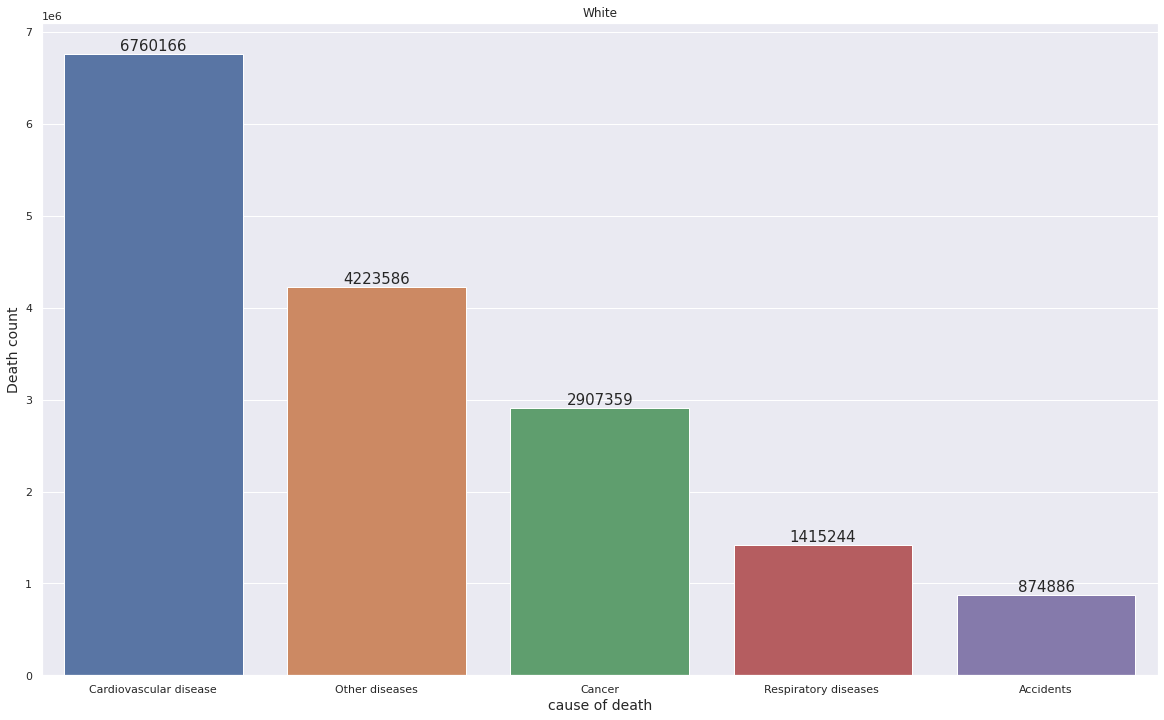

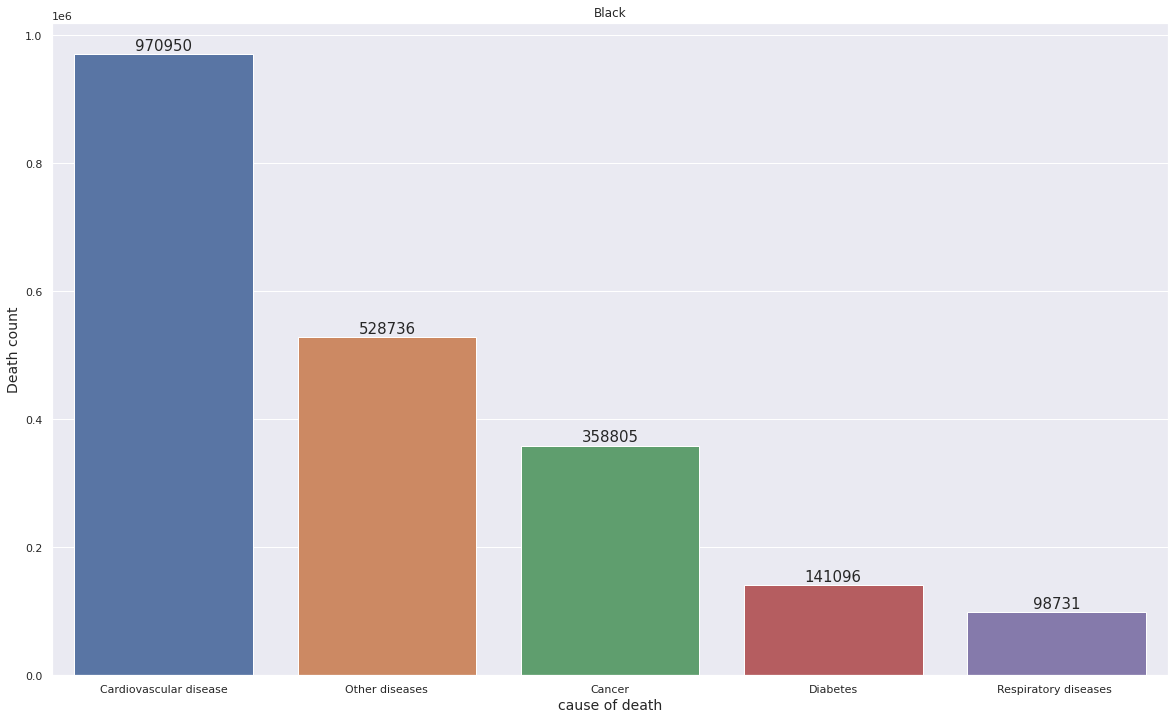

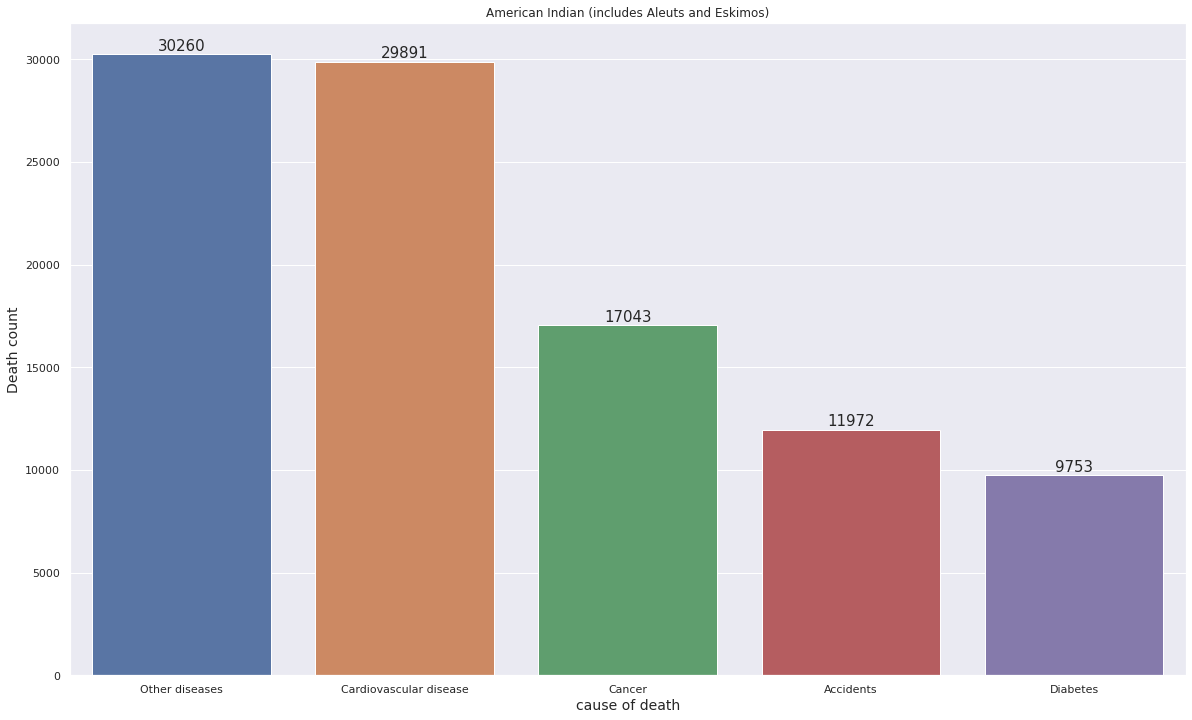

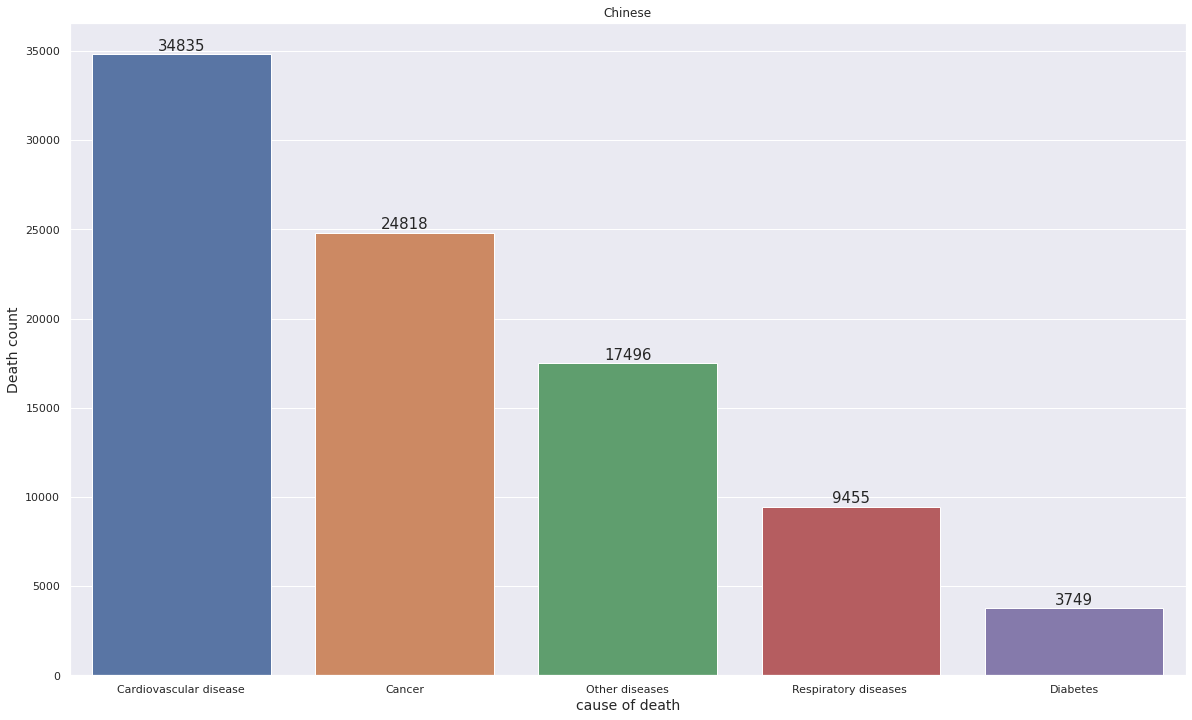

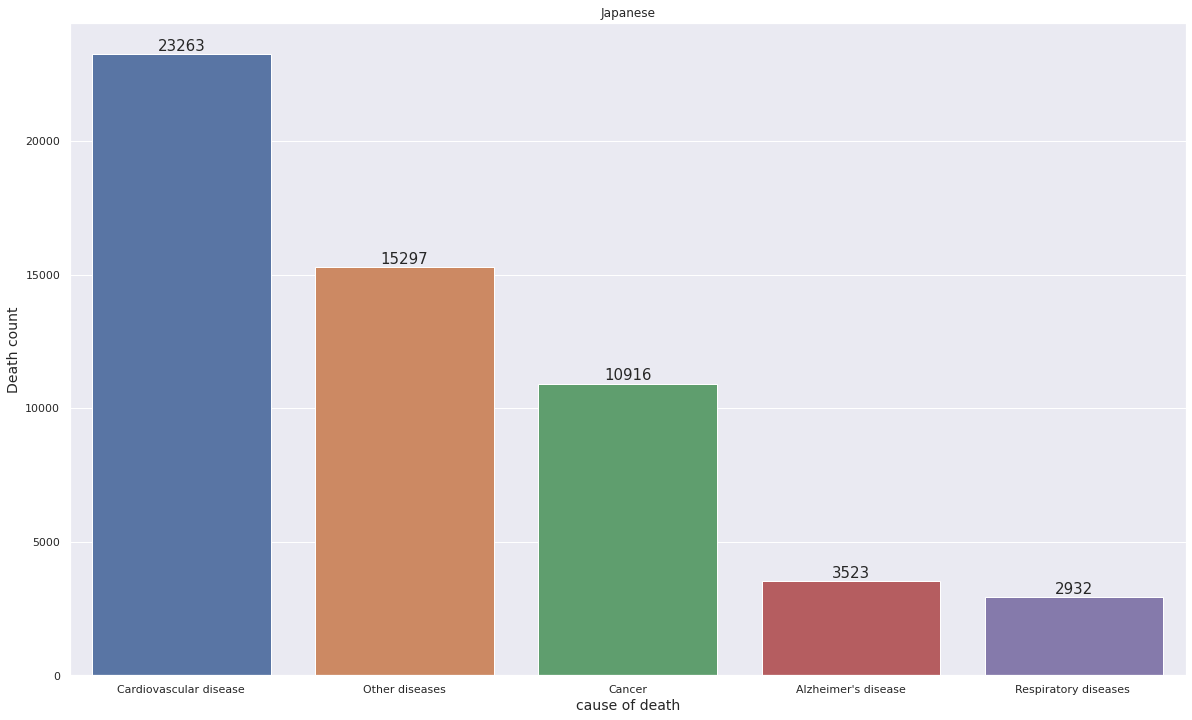

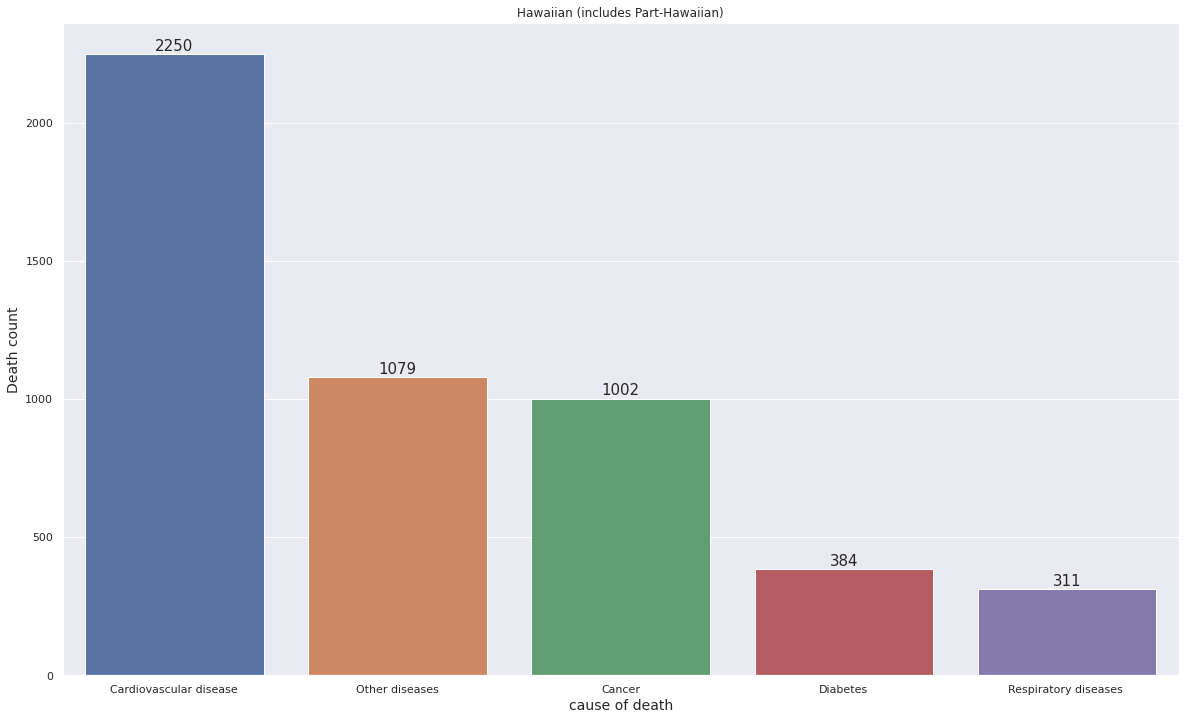

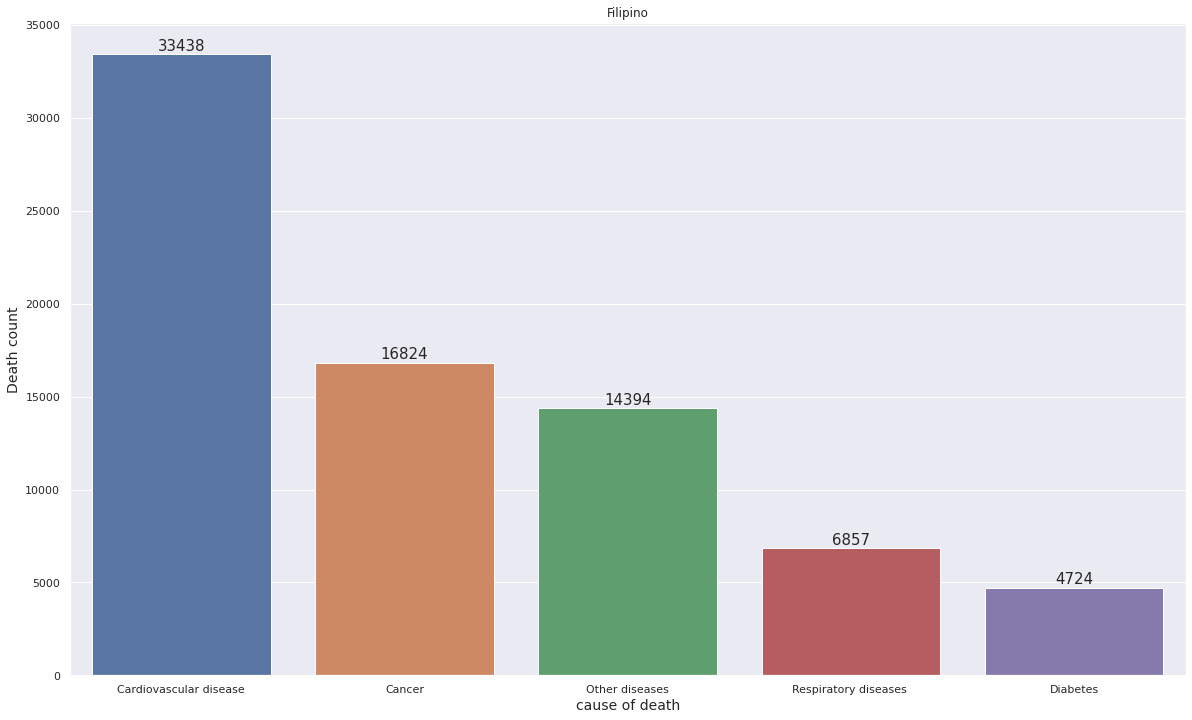

In [300]:
df1=[]
df2=[]
for i,race_id in enumerate(codes['race'].keys()): 
  path=f'/content/drive/MyDrive/Colab Notebooks/BigData/Final project/results/COD_race/race_{race_id}.csv'
  image_path=f'/content/drive/MyDrive/Colab Notebooks/BigData/Final project/results/COD_race/imgs/race_{race_id}.png'
  df=pd.read_csv(path)
  df['race']=df['race'].apply(lambda x:codes['race'][race_id])
  # df['39_cause_recode']=df['39_cause_recode'].apply(lambda x:str(x))
  df['39_cause_recode']=df['39_cause_recode'].apply(lambda x:cause_recode[x])
  df=df.groupby(['race','39_cause_recode']).sum().reset_index().head(20)
  # df.head(20)
  try:
    df.rename(columns={'39_cause_recode':'cause_recode'},inplace=True)
    df.sort_values(by=['count','cause_recode'],ascending=False,inplace=True)
    title=df['race'][0]
    df=df.head(5)
    df=df[["race","cause_recode","count"]]
    bar_plot("cause_recode","count",df,title,image_path)
    if df['race'][0]!='White' and df['race'][0]!='Black' : df1.append(df)
    else : df2.append(df)
    if i>5 :break
  except:
    pass  

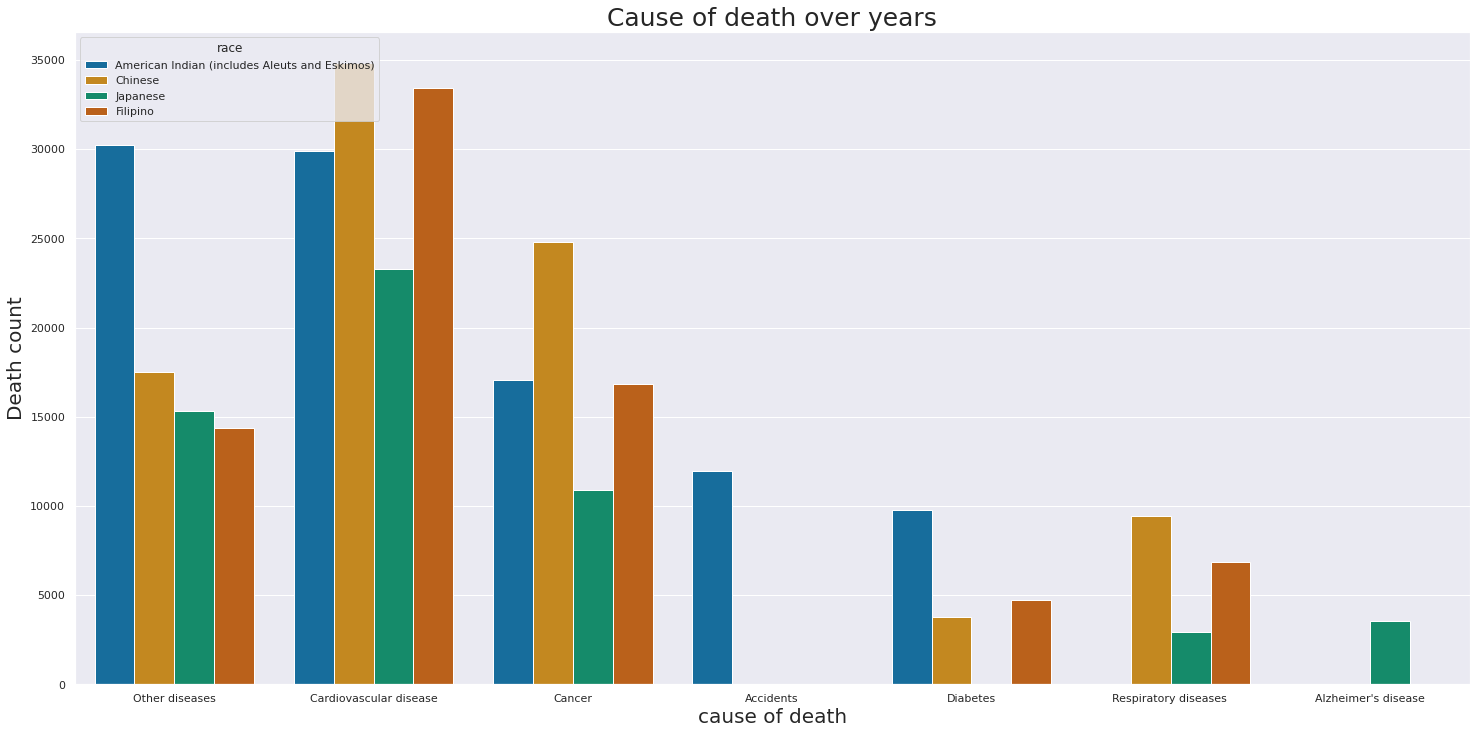

In [301]:
df1 = [df.set_index('race') for df in df1]
dfg=pd.concat(df1, axis=0).reset_index()

plt.figure(figsize=(25, 12)) 

sns.barplot(x = "cause_recode", y = "count", hue = "race", ci = "sd", palette='colorblind',capsize = 0.5, data = dfg)
  
# # Iterrating over the bars one-by-one 
# for bar in plots.patches: 
    
#   # Using Matplotlib's annotate function and 
#   # passing the coordinates where the annotation shall be done 
#   # x-coordinate: bar.get_x() + bar.get_width() / 2 
#   # y-coordinate: bar.get_height() 
#   # free space to be left to make graph pleasing: (0, 8) 
#   # ha and va stand for the horizontal and vertical alignment 
#   plots.annotate(format(bar.get_height(), '.0f'),  
#                   (bar.get_x() + bar.get_width() / 2,  
#                     bar.get_height()), ha='center', va='center', 
#                   size=15, xytext=(0, 8), 
#                   textcoords='offset points') 
  
# Setting the label for x-axis 
plt.xlabel("cause of death", size=20) 
  
# Setting the label for y-axis 
plt.ylabel("Death count", size=20) 
  
# Setting the title for the graph 
plt.title("Cause of death over years",size=25) 
  
# Fianlly showing the plot 
plt.show() 


## For each gender

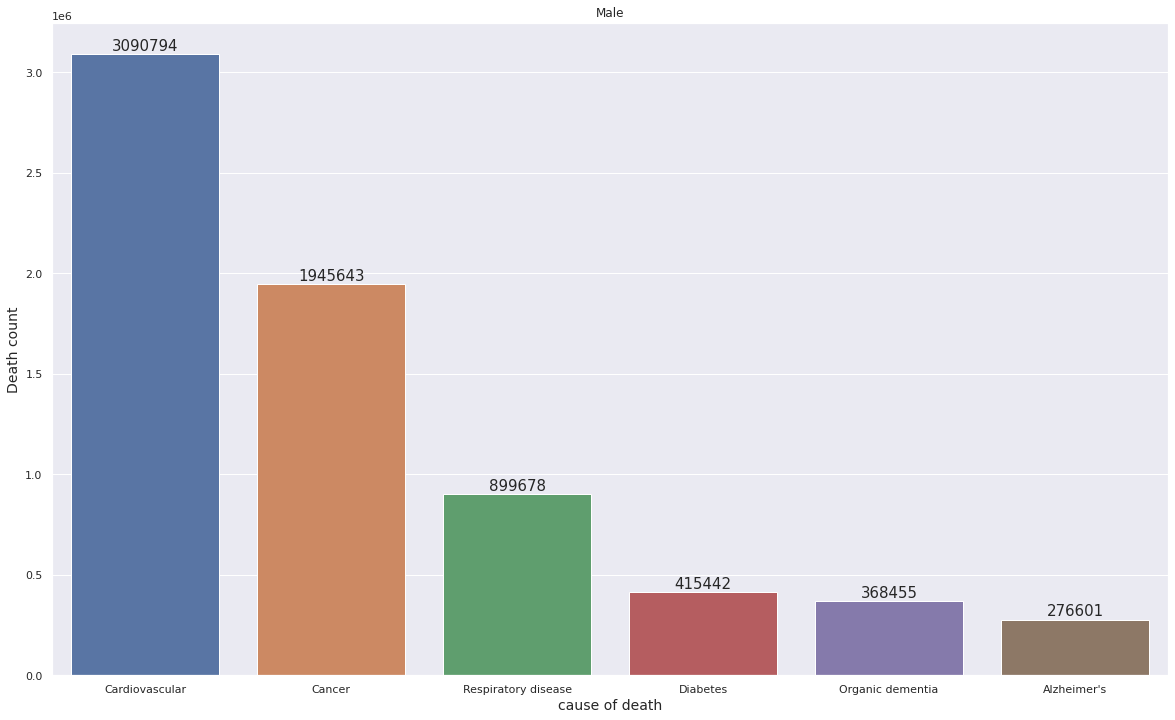

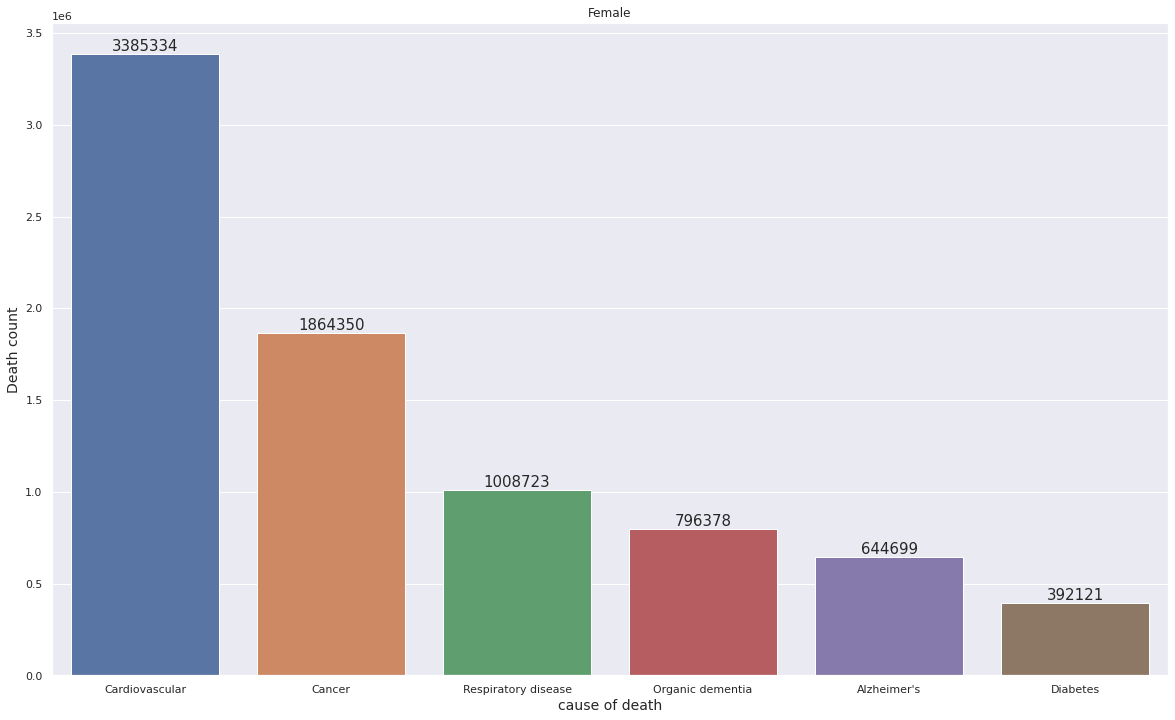

In [290]:
dfs=[]
for gender_id in codes['sex'].keys(): 
  path=f'/content/drive/MyDrive/Colab Notebooks/BigData/Final project/results/COD_gender/gender_{gender_id}.csv'
  df=pd.read_csv(path)
  df['sex']=df['sex'].apply(lambda x:codes['sex'][gender_id])
  # df['358_cause_recode']=df['358_cause_recode'].apply(lambda x:str(x))
  df['358_cause_recode']=df['358_cause_recode'].apply(lambda x:cause_recode_big[x])
  df=df.groupby(['sex','358_cause_recode']).sum().reset_index().head(20)
  df.rename(columns={'358_cause_recode':'cause_recode'},inplace=True)
  df.sort_values(by=['count','cause_recode'],ascending=False,inplace=True)
  title=df['sex'][0]
  df=df.head(6)
  df=df[['sex',"cause_recode","count"]]
  dfs.append(df)
  bar_plot("cause_recode","count",df,title,image_path)

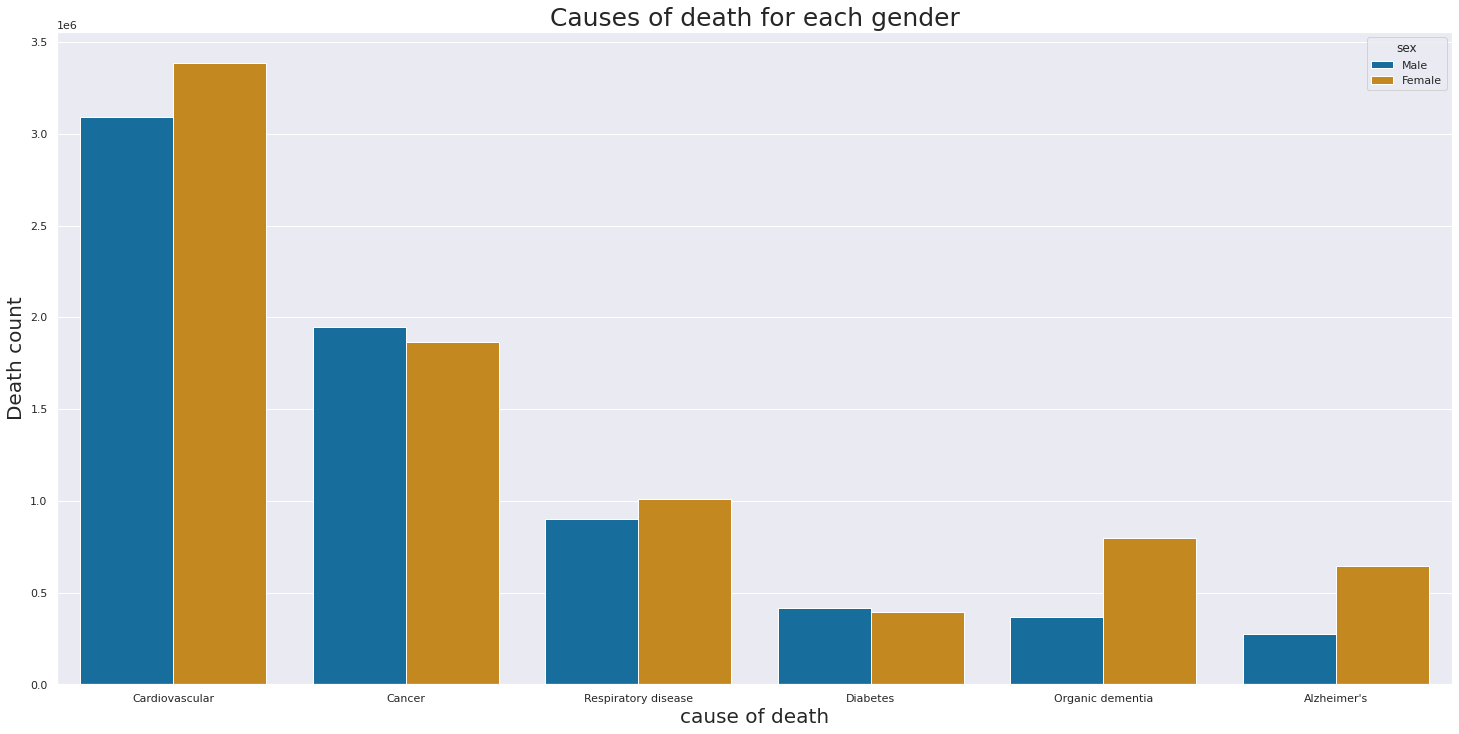

In [291]:
dfs = [df.set_index('sex') for df in dfs]
dfg=pd.concat(dfs, axis=0).reset_index()

plt.figure(figsize=(25, 12)) 

sns.barplot(x = "cause_recode", y = "count", hue = "sex", ci = "sd", palette='colorblind',capsize = 0.5, data = dfg)
  
# # Iterrating over the bars one-by-one 
# for bar in plots.patches: 
    
#   # Using Matplotlib's annotate function and 
#   # passing the coordinates where the annotation shall be done 
#   # x-coordinate: bar.get_x() + bar.get_width() / 2 
#   # y-coordinate: bar.get_height() 
#   # free space to be left to make graph pleasing: (0, 8) 
#   # ha and va stand for the horizontal and vertical alignment 
#   plots.annotate(format(bar.get_height(), '.0f'),  
#                   (bar.get_x() + bar.get_width() / 2,  
#                     bar.get_height()), ha='center', va='center', 
#                   size=15, xytext=(0, 8), 
#                   textcoords='offset points') 
  
# Setting the label for x-axis 
plt.xlabel("cause of death", size=20) 
  
# Setting the label for y-axis 
plt.ylabel("Death count", size=20) 
  
# Setting the title for the graph 
plt.title("Causes of death for each gender",size=25) 
  
# Fianlly showing the plot 
plt.show() 


## Death For each weekday 

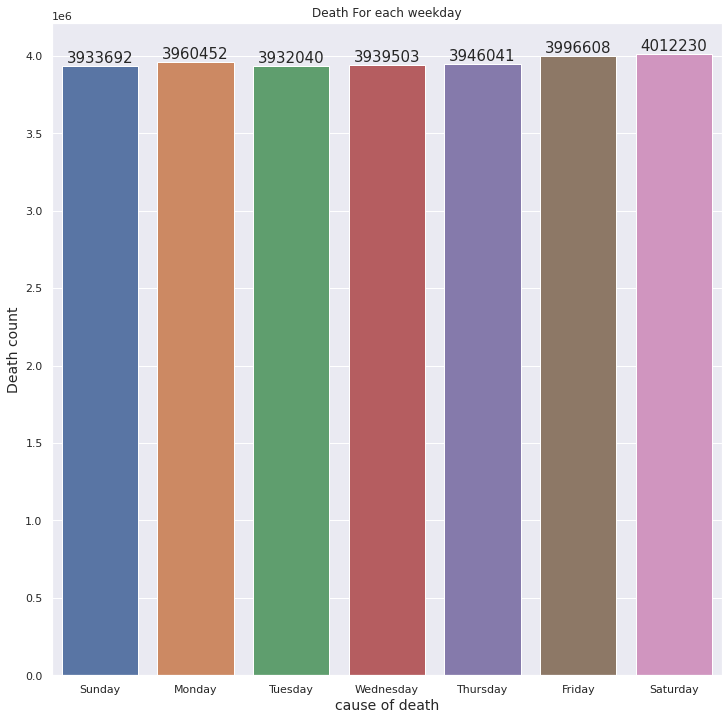

In [278]:
path="/content/drive/MyDrive/Colab Notebooks/BigData/Final project/results/weekday.csv"
df=pd.read_csv(path).sort_values(by=['day_of_week_of_death'])
days=codes['day_of_week_of_death']
days_recode={int(k):v for k,v in days.items()}
days_recode
df['day_of_week_of_death']=df['day_of_week_of_death'].apply(lambda x:days_recode[x])
df=df[['day_of_week_of_death','count']]
bar_plot("day_of_week_of_death",'count',df,'Death For each weekday','')


In [277]:
df

,day_of_week_of_death,count
5,Sunday,3933692
2,Monday,3960452
6,Tuesday,3932040
4,Wednesday,3939503
3,Thursday,3946041
1,Friday,3996608
0,Saturday,4012230


In [265]:
days_recode

{1: 'Sunday',
 2: 'Monday',
 3: 'Tuesday',
 4: 'Wednesday',
 5: 'Thursday',
 6: 'Friday',
 7: 'Saturday',
 9: 'Unknown'}

##Death count For each Month

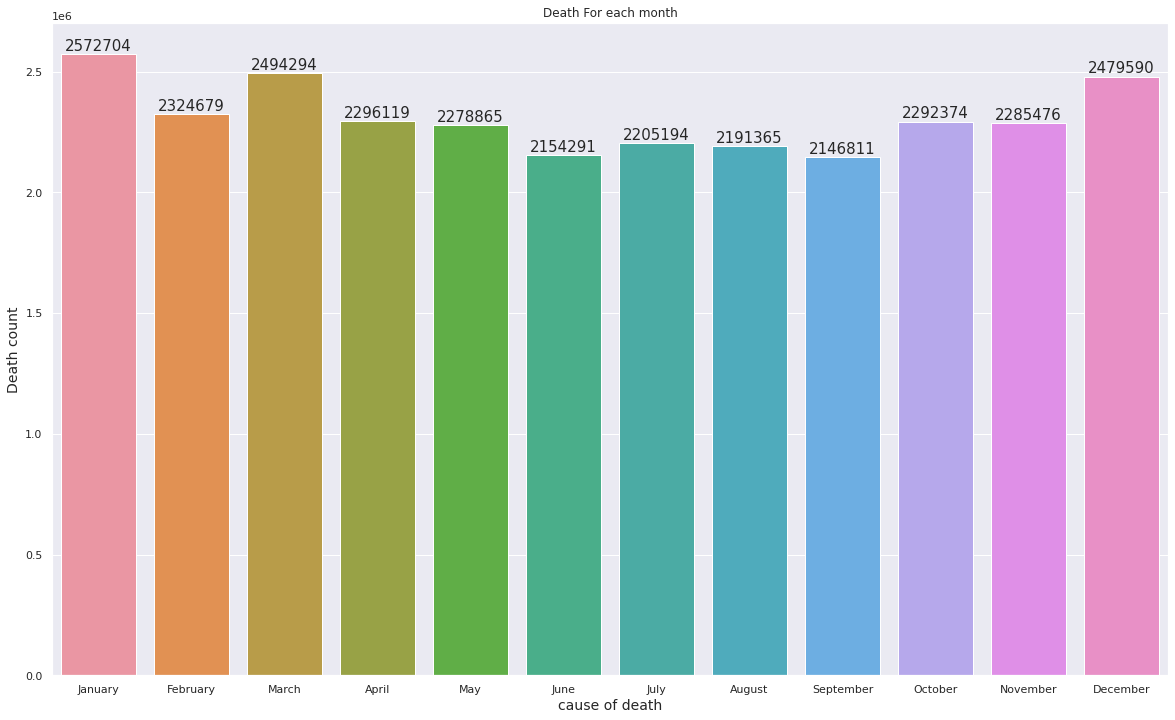

In [284]:
path="/content/drive/MyDrive/Colab Notebooks/BigData/Final project/results/month.csv"
df=pd.read_csv(path).sort_values(by=['month_of_death'])
months=codes['month_of_death']
months_recode={int(k):v for k,v in months.items()}
df['month_of_death']=df['month_of_death'].apply(lambda x:months_recode[x])
df=df[['month_of_death','count']]
bar_plot("month_of_death",'count',df,'Death For each month','')


## Cause of death and seasons

In [285]:
seasons={"summer":("06","07","08"),
         "fall":("09","10","11"),
         "winter":("11","12","10"),
         "spring":("03","04","05")}


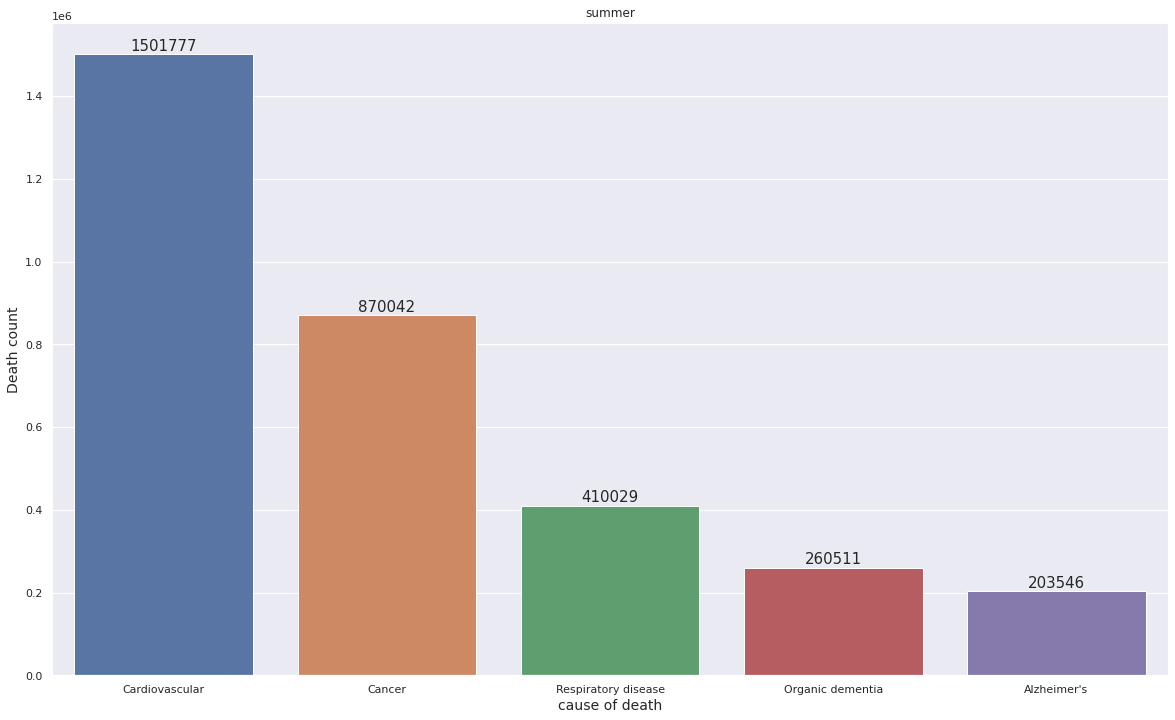

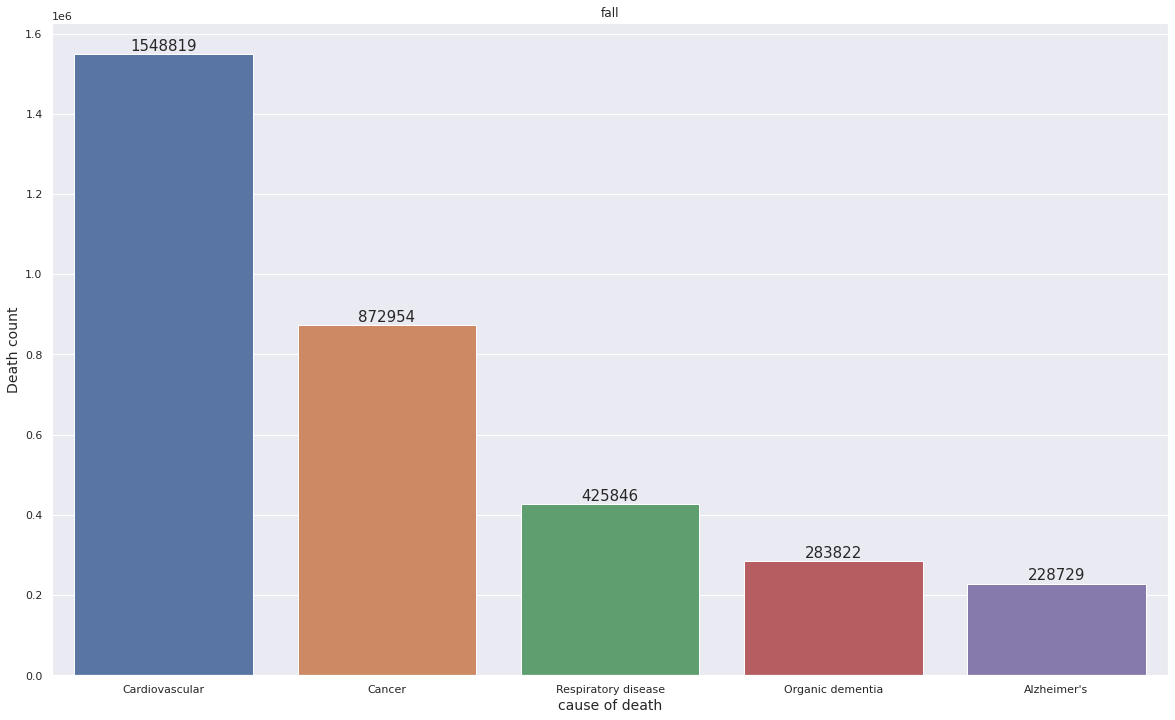

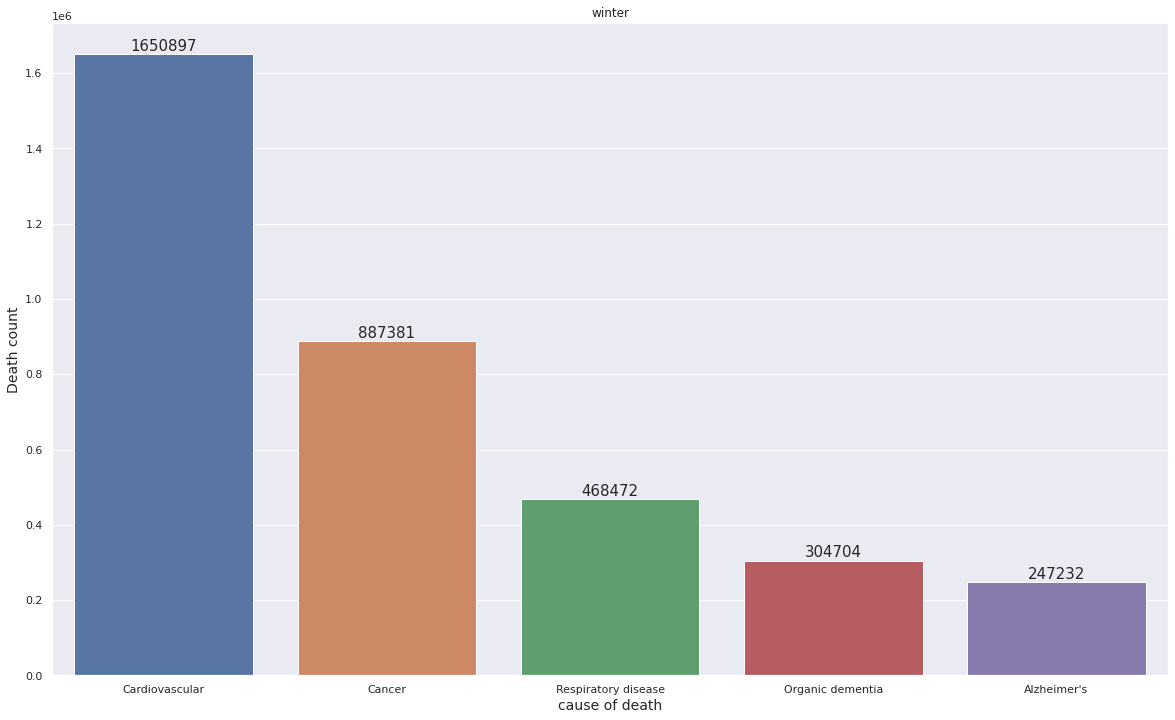

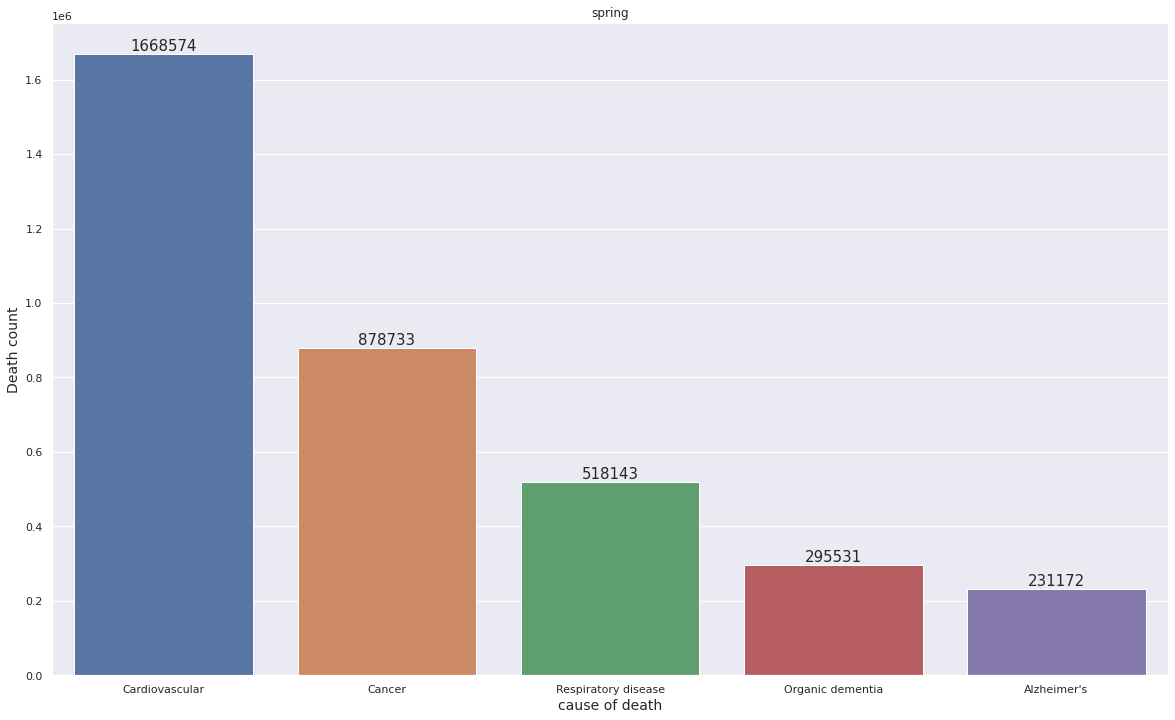

In [286]:
dfs=[]
for season in seasons.keys(): 
  path=f'/content/drive/MyDrive/Colab Notebooks/BigData/Final project/results/COD_season/season_{season}.csv'
  df=pd.read_csv(path)
  df.head()
  # df['sex']=df['sex'].apply(lambda x:codes['sex'][gender_id])
  # df['358_cause_recode']=df['358_cause_recode'].apply(lambda x:str(x))
  df['358_cause_recode']=df['358_cause_recode'].apply(lambda x:cause_recode_big[x])
  df=df.groupby(['358_cause_recode']).sum().reset_index().head(20)
  df.rename(columns={'358_cause_recode':'cause_recode'},inplace=True)
  df.sort_values(by=['count','cause_recode'],ascending=False,inplace=True)
  title=season
  df=df.head(5)
  df=df[["cause_recode","count"]]
  df["season"]=season
  bar_plot("cause_recode","count",df,title,image_path)
  dfs.append(df)

In [287]:
dfs[0].head()

,cause_recode,count,season
3,Cardiovascular,1501777,summer
2,Cancer,870042,summer
7,Respiratory disease,410029,summer
5,Organic dementia,260511,summer
1,Alzheimer's,203546,summer


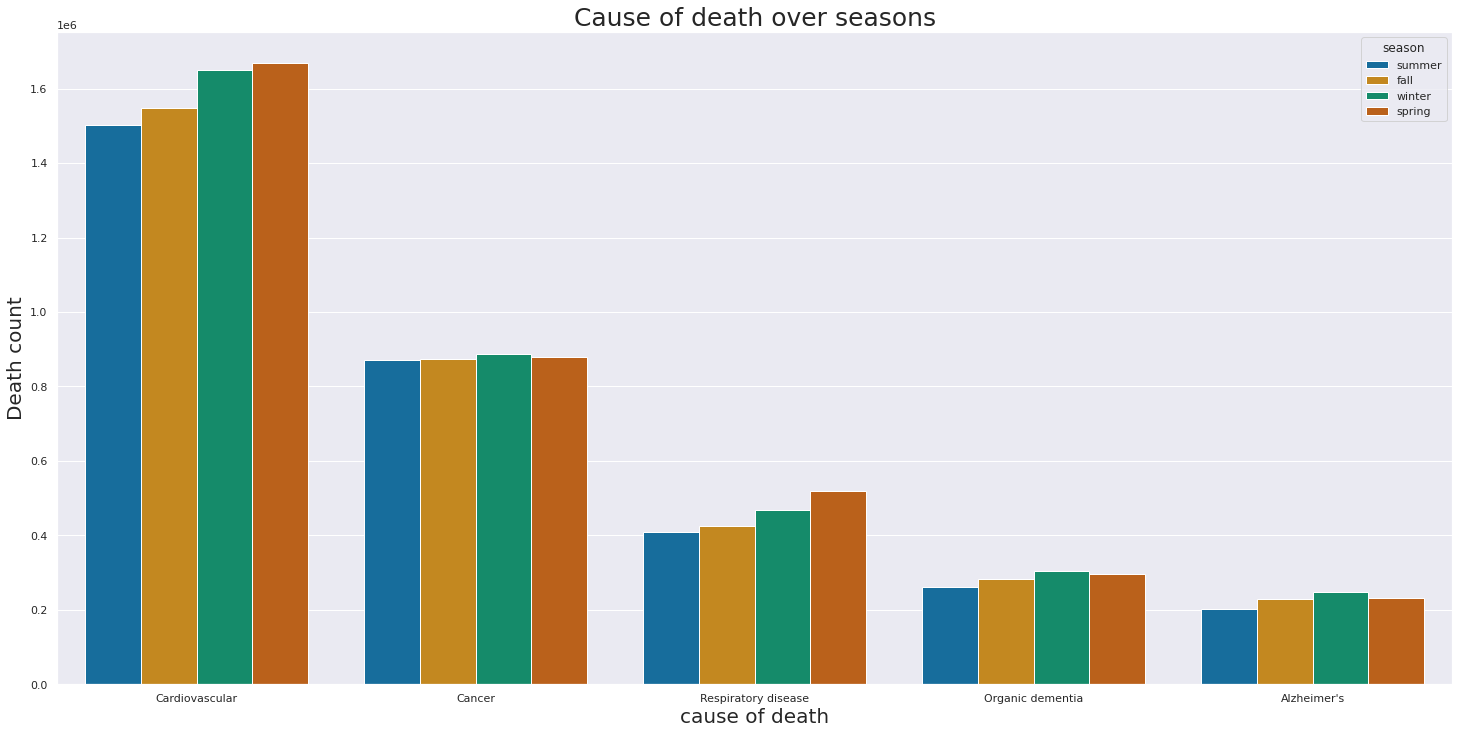

In [288]:
dfs = [df.set_index('season') for df in dfs]
dfg=pd.concat(dfs, axis=0).reset_index()

plt.figure(figsize=(25, 12)) 

sns.barplot(x = "cause_recode", y = "count", hue = "season", ci = "sd", palette='colorblind',capsize = 0.5, data = dfg)
  
# # Iterrating over the bars one-by-one 
# for bar in plots.patches: 
    
#   # Using Matplotlib's annotate function and 
#   # passing the coordinates where the annotation shall be done 
#   # x-coordinate: bar.get_x() + bar.get_width() / 2 
#   # y-coordinate: bar.get_height() 
#   # free space to be left to make graph pleasing: (0, 8) 
#   # ha and va stand for the horizontal and vertical alignment 
#   plots.annotate(format(bar.get_height(), '.0f'),  
#                   (bar.get_x() + bar.get_width() / 2,  
#                     bar.get_height()), ha='center', va='center', 
#                   size=15, xytext=(0, 8), 
#                   textcoords='offset points') 
  
# Setting the label for x-axis 
plt.xlabel("cause of death", size=20) 
  
# Setting the label for y-axis 
plt.ylabel("Death count", size=20) 
  
# Setting the title for the graph 
plt.title("Cause of death over seasons",size=25) 
  
# Fianlly showing the plot 
plt.show() 


## Cause of death for each year

In [209]:
years=["2005","2006","2007","2008","2009","2010","2011","2012","2013","2014","2015"]
plt.figure(figsize=(12, 12)) 

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

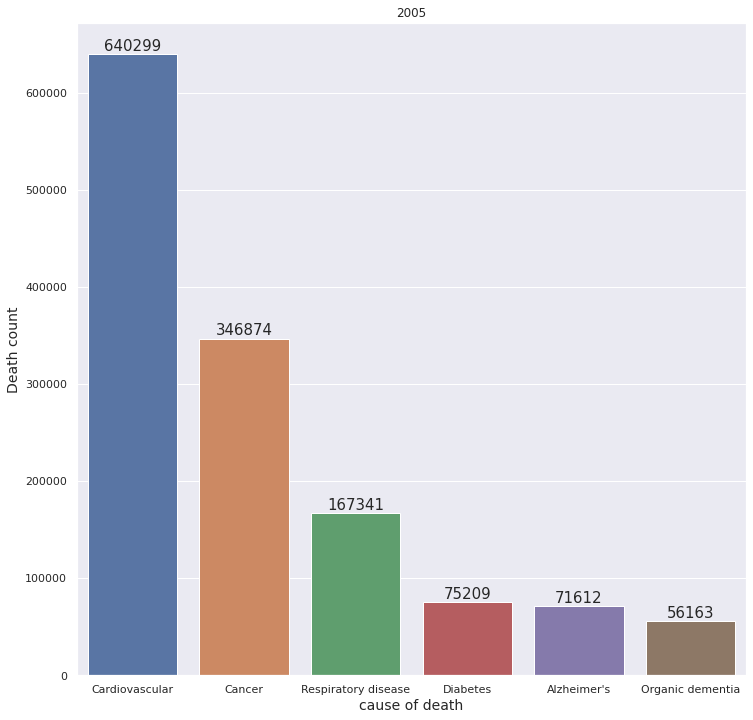

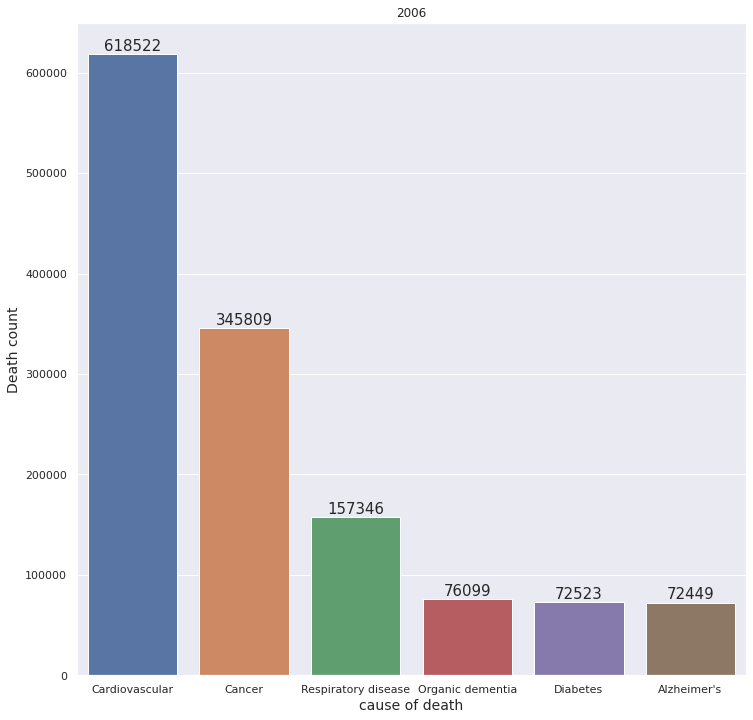

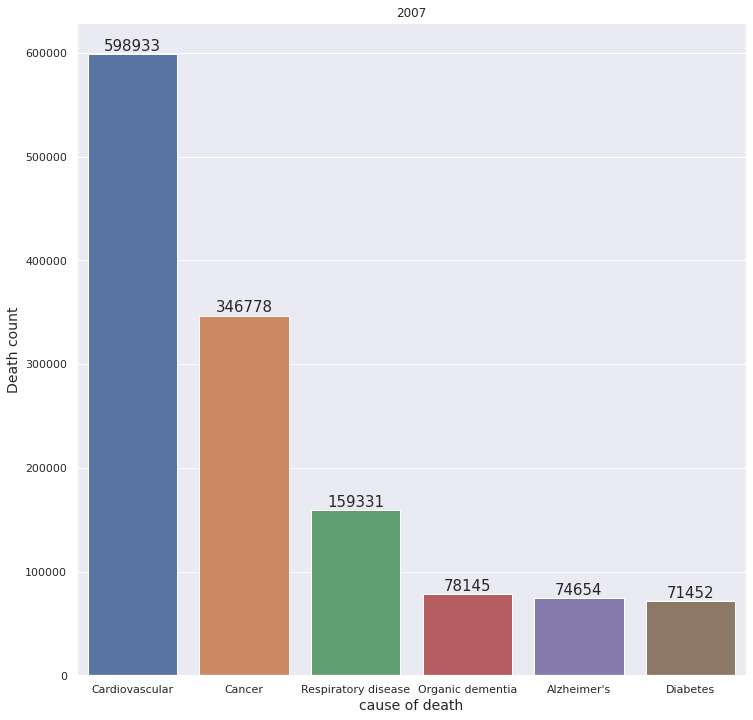

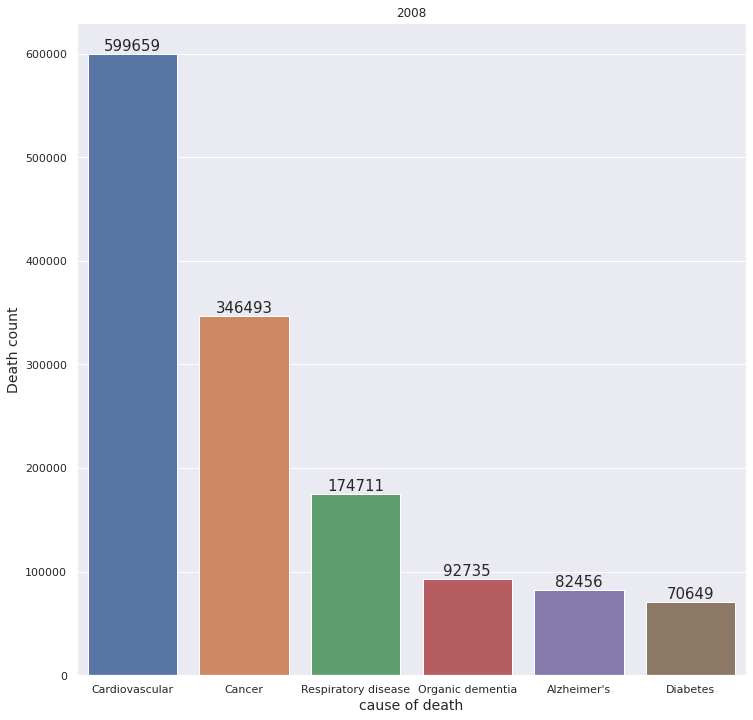

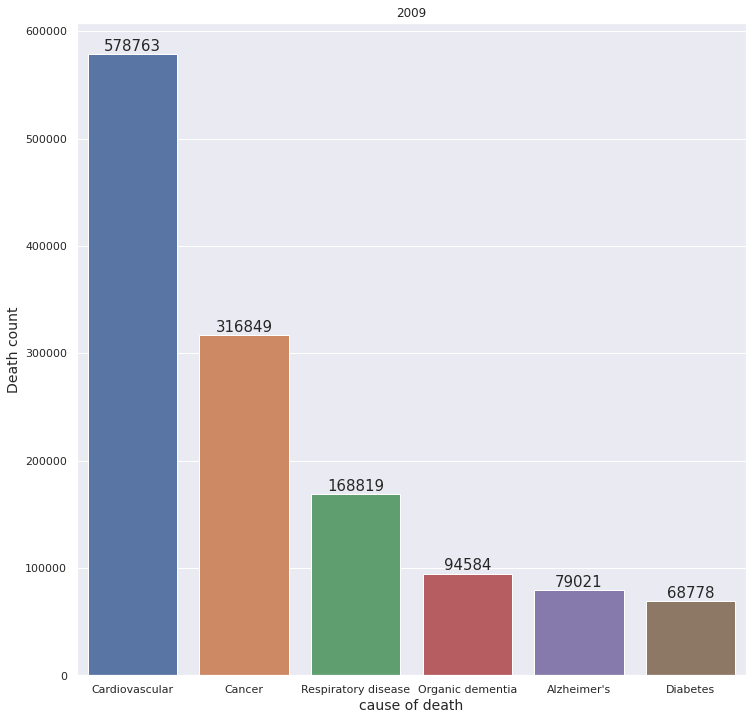

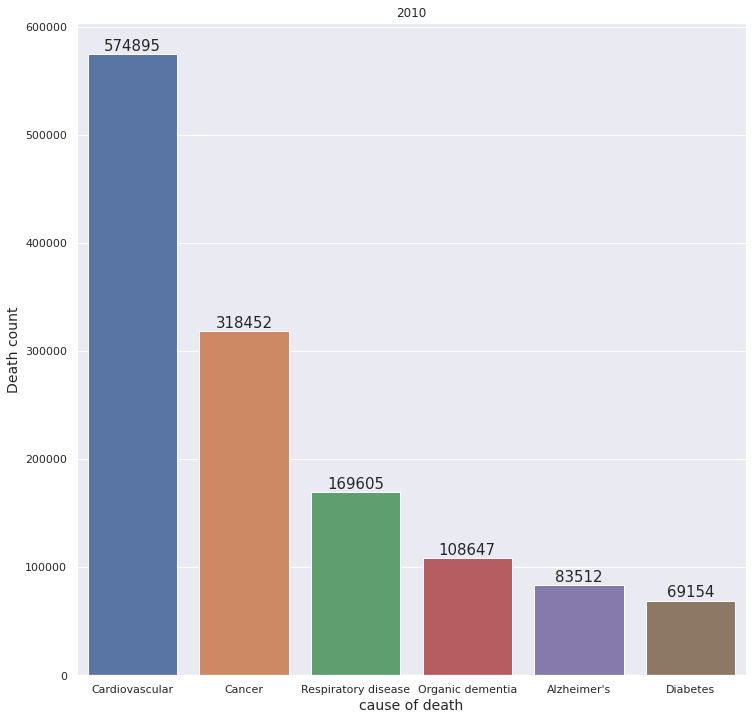

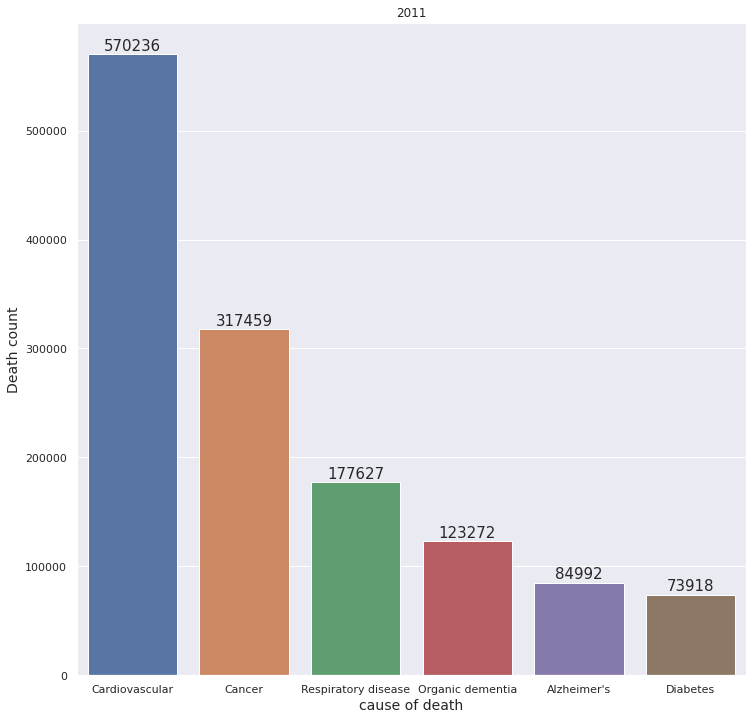

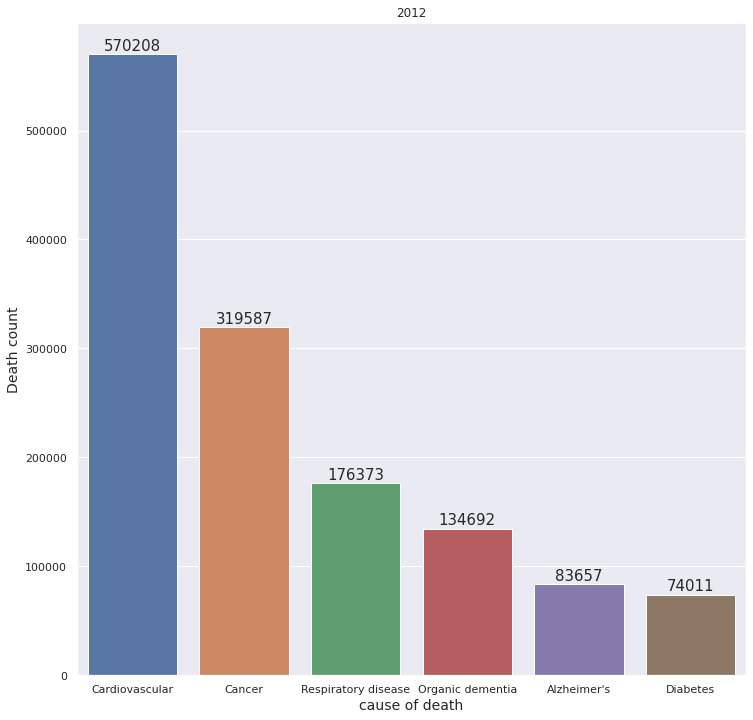

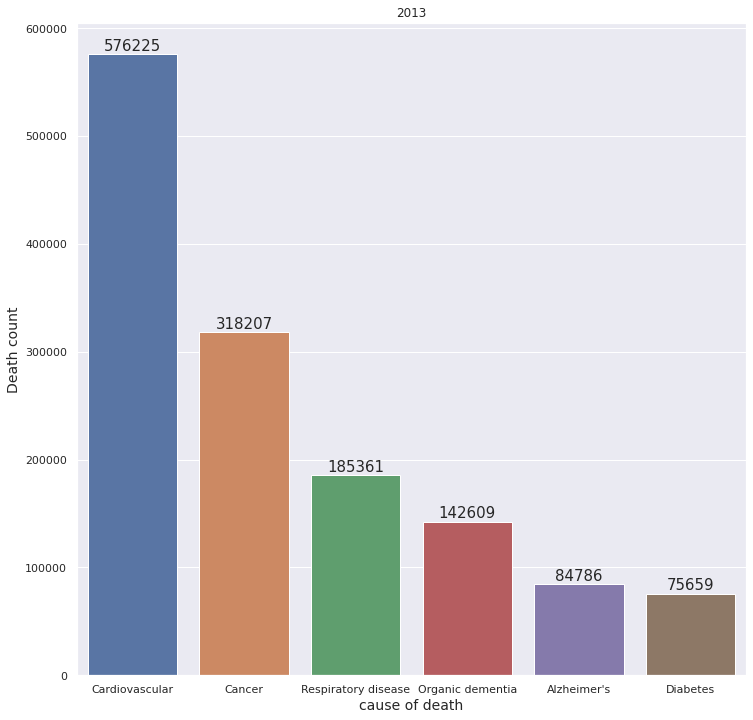

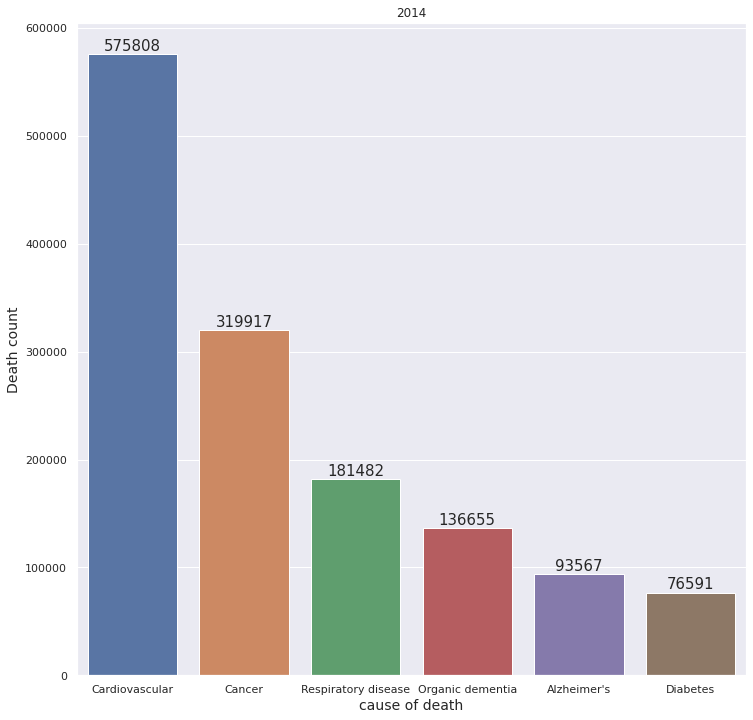

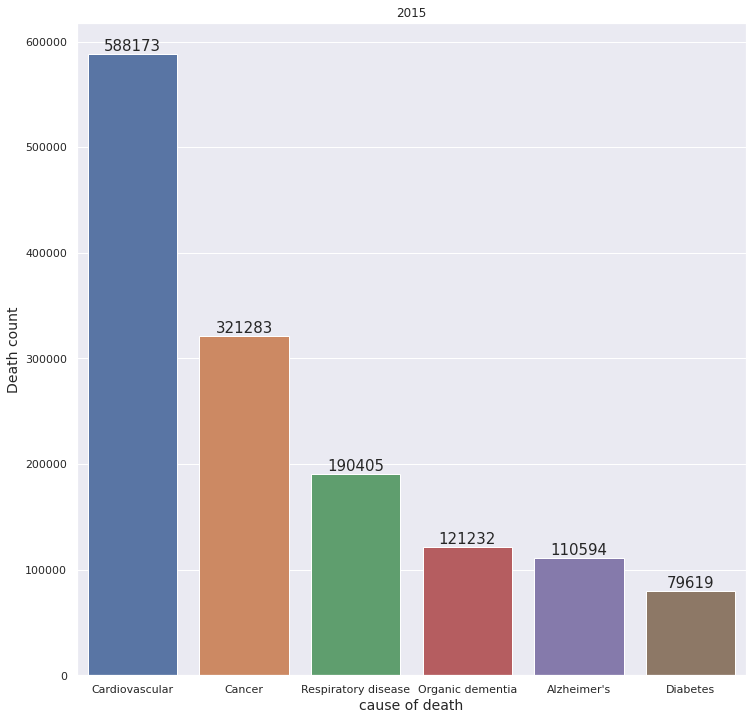

In [210]:
dfs=[]
for year in years: 
  path=f'/content/drive/MyDrive/Colab Notebooks/BigData/Final project/results/COD_per_year/year_{year}.csv'
  df=pd.read_csv(path)
  df.head()
  # df['358_cause_recode']=df['358_cause_recode'].apply(lambda x:str(x))
  df['358_cause_recode']=df['358_cause_recode'].apply(lambda x:cause_recode_big[x])
  df=df.groupby(['current_data_year','358_cause_recode']).sum().reset_index().head(20)
  df.rename(columns={'358_cause_recode':'cause_recode'},inplace=True)
  df.sort_values(by=['count','cause_recode'],ascending=False,inplace=True)
  title=year
  df=df.head(6)
  df=df[['current_data_year',"cause_recode","count"]]
  dfs.append(df)
  bar_plot("cause_recode","count",df,title,image_path)     

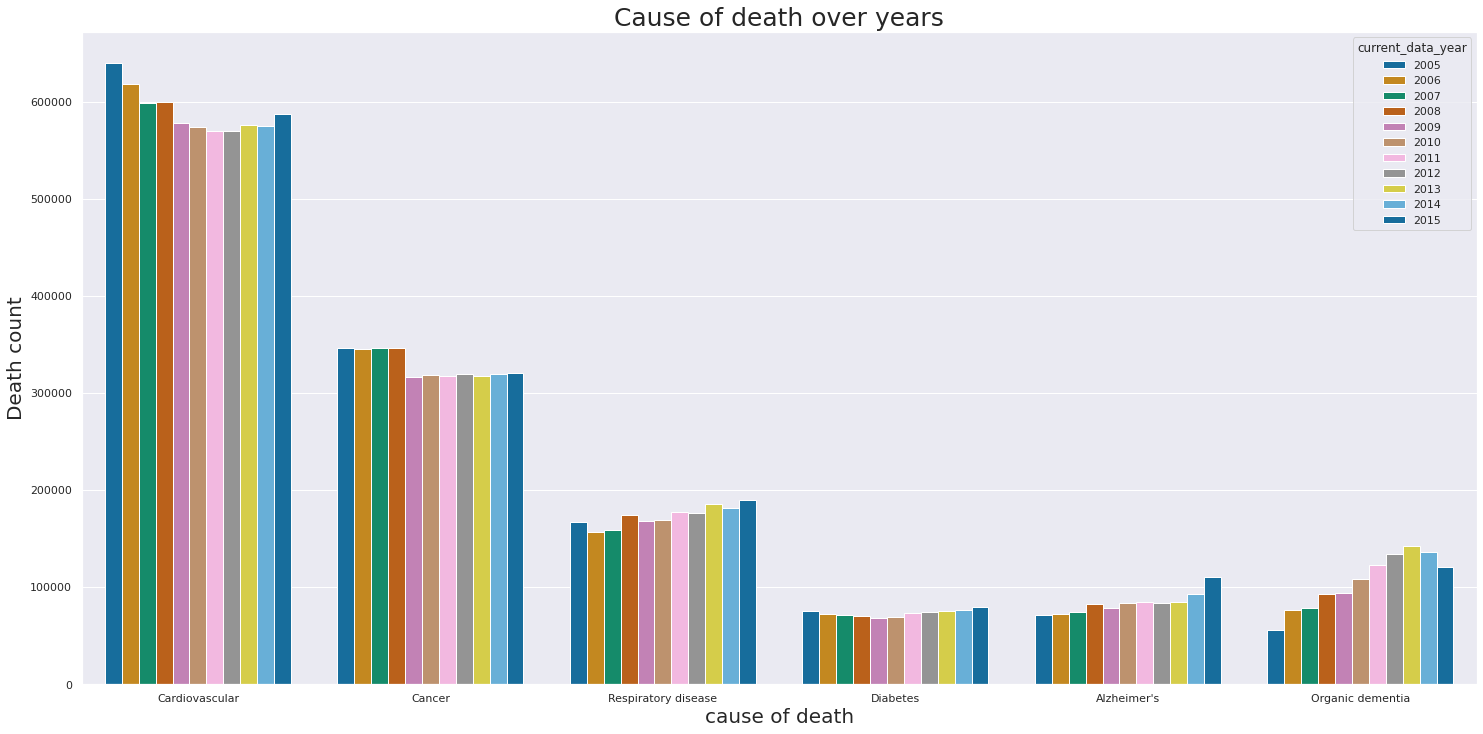

In [211]:
dfs = [df.set_index('current_data_year') for df in dfs]
dfg=pd.concat(dfs, axis=0).reset_index()

plt.figure(figsize=(25, 12)) 

sns.barplot(x = "cause_recode", y = "count", hue = "current_data_year", ci = "sd",palette='colorblind' ,capsize = 0.5, data = dfg)
  
# # Iterrating over the bars one-by-one 
# for bar in plots.patches: 
    
#   # Using Matplotlib's annotate function and 
#   # passing the coordinates where the annotation shall be done 
#   # x-coordinate: bar.get_x() + bar.get_width() / 2 
#   # y-coordinate: bar.get_height() 
#   # free space to be left to make graph pleasing: (0, 8) 
#   # ha and va stand for the horizontal and vertical alignment 
#   plots.annotate(format(bar.get_height(), '.0f'),  
#                   (bar.get_x() + bar.get_width() / 2,  
#                     bar.get_height()), ha='center', va='center', 
#                   size=15, xytext=(0, 8), 
#                   textcoords='offset points') 
  
# Setting the label for x-axis 
plt.xlabel("cause of death", size=20) 
  
# Setting the label for y-axis 
plt.ylabel("Death count", size=20) 
  
# Setting the title for the graph 
plt.title("Cause of death over years",size=25) 
  
# Fianlly showing the plot 
plt.show() 
